# Sunlight Harvesting Energy Conversion

In [181]:
import math
import random
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

import nmf.nmf as nmf
import knee.kneedle as kneedle

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import OneHotEncoder

## Dataset visualization and analysis

In [182]:
df = pl.read_excel('db.xlsx')
df = df.drop(['#'])
df

shape: (176, 11)
┌──────┬──────┬──────────┬─────────┬─────┬────────┬────────┬──────────┬─────────┐
│ mat0 ┆ mat1 ┆ abs_peak ┆ abs_min ┆ ... ┆ em_max ┆ QY (%) ┆ hopt (%) ┆ PCE (%) │
│ ---  ┆ ---  ┆ ---      ┆ ---     ┆     ┆ ---    ┆ ---    ┆ ---      ┆ ---     │
│ str  ┆ str  ┆ i64      ┆ i64     ┆     ┆ i64    ┆ f64    ┆ f64      ┆ f64     │
╞══════╪══════╪══════════╪═════════╪═════╪════════╪════════╪══════════╪═════════╡
│ dye  ┆ film ┆ 578      ┆ 420     ┆ ... ┆ 750    ┆ 98.0   ┆ 18.8     ┆ null    │
│ dye  ┆ bulk ┆ 540      ┆ 400     ┆ ... ┆ 690    ┆ null   ┆ null     ┆ null    │
│ dye  ┆ bulk ┆ 540      ┆ 400     ┆ ... ┆ 690    ┆ null   ┆ null     ┆ null    │
│ QD   ┆ bulk ┆ 730      ┆ 600     ┆ ... ┆ 1000   ┆ null   ┆ 2.5      ┆ null    │
│ ...  ┆ ...  ┆ ...      ┆ ...     ┆ ... ┆ ...    ┆ ...    ┆ ...      ┆ ...     │
│ QD   ┆ bulk ┆ 600      ┆ 400     ┆ ... ┆ 700    ┆ 30.0   ┆ 2.7      ┆ 0.38    │
│ QD   ┆ bulk ┆ 350      ┆ 300     ┆ ... ┆ 700    ┆ 91.0   ┆ null     ┆ 4.29    │
│ QD   ┆ bulk ┆ 350      ┆ 300     ┆ ... ┆ 700    ┆ 91.0   ┆ null     ┆ 0.55    │
│ QD   ┆ bulk ┆ 350      ┆ 300     ┆ ... ┆ 700    ┆ 11.0   ┆ null     ┆ 0.77    │
└──────┴──────┴──────────┴─────────┴─────┴────────┴────────┴──────────┴─────────┘

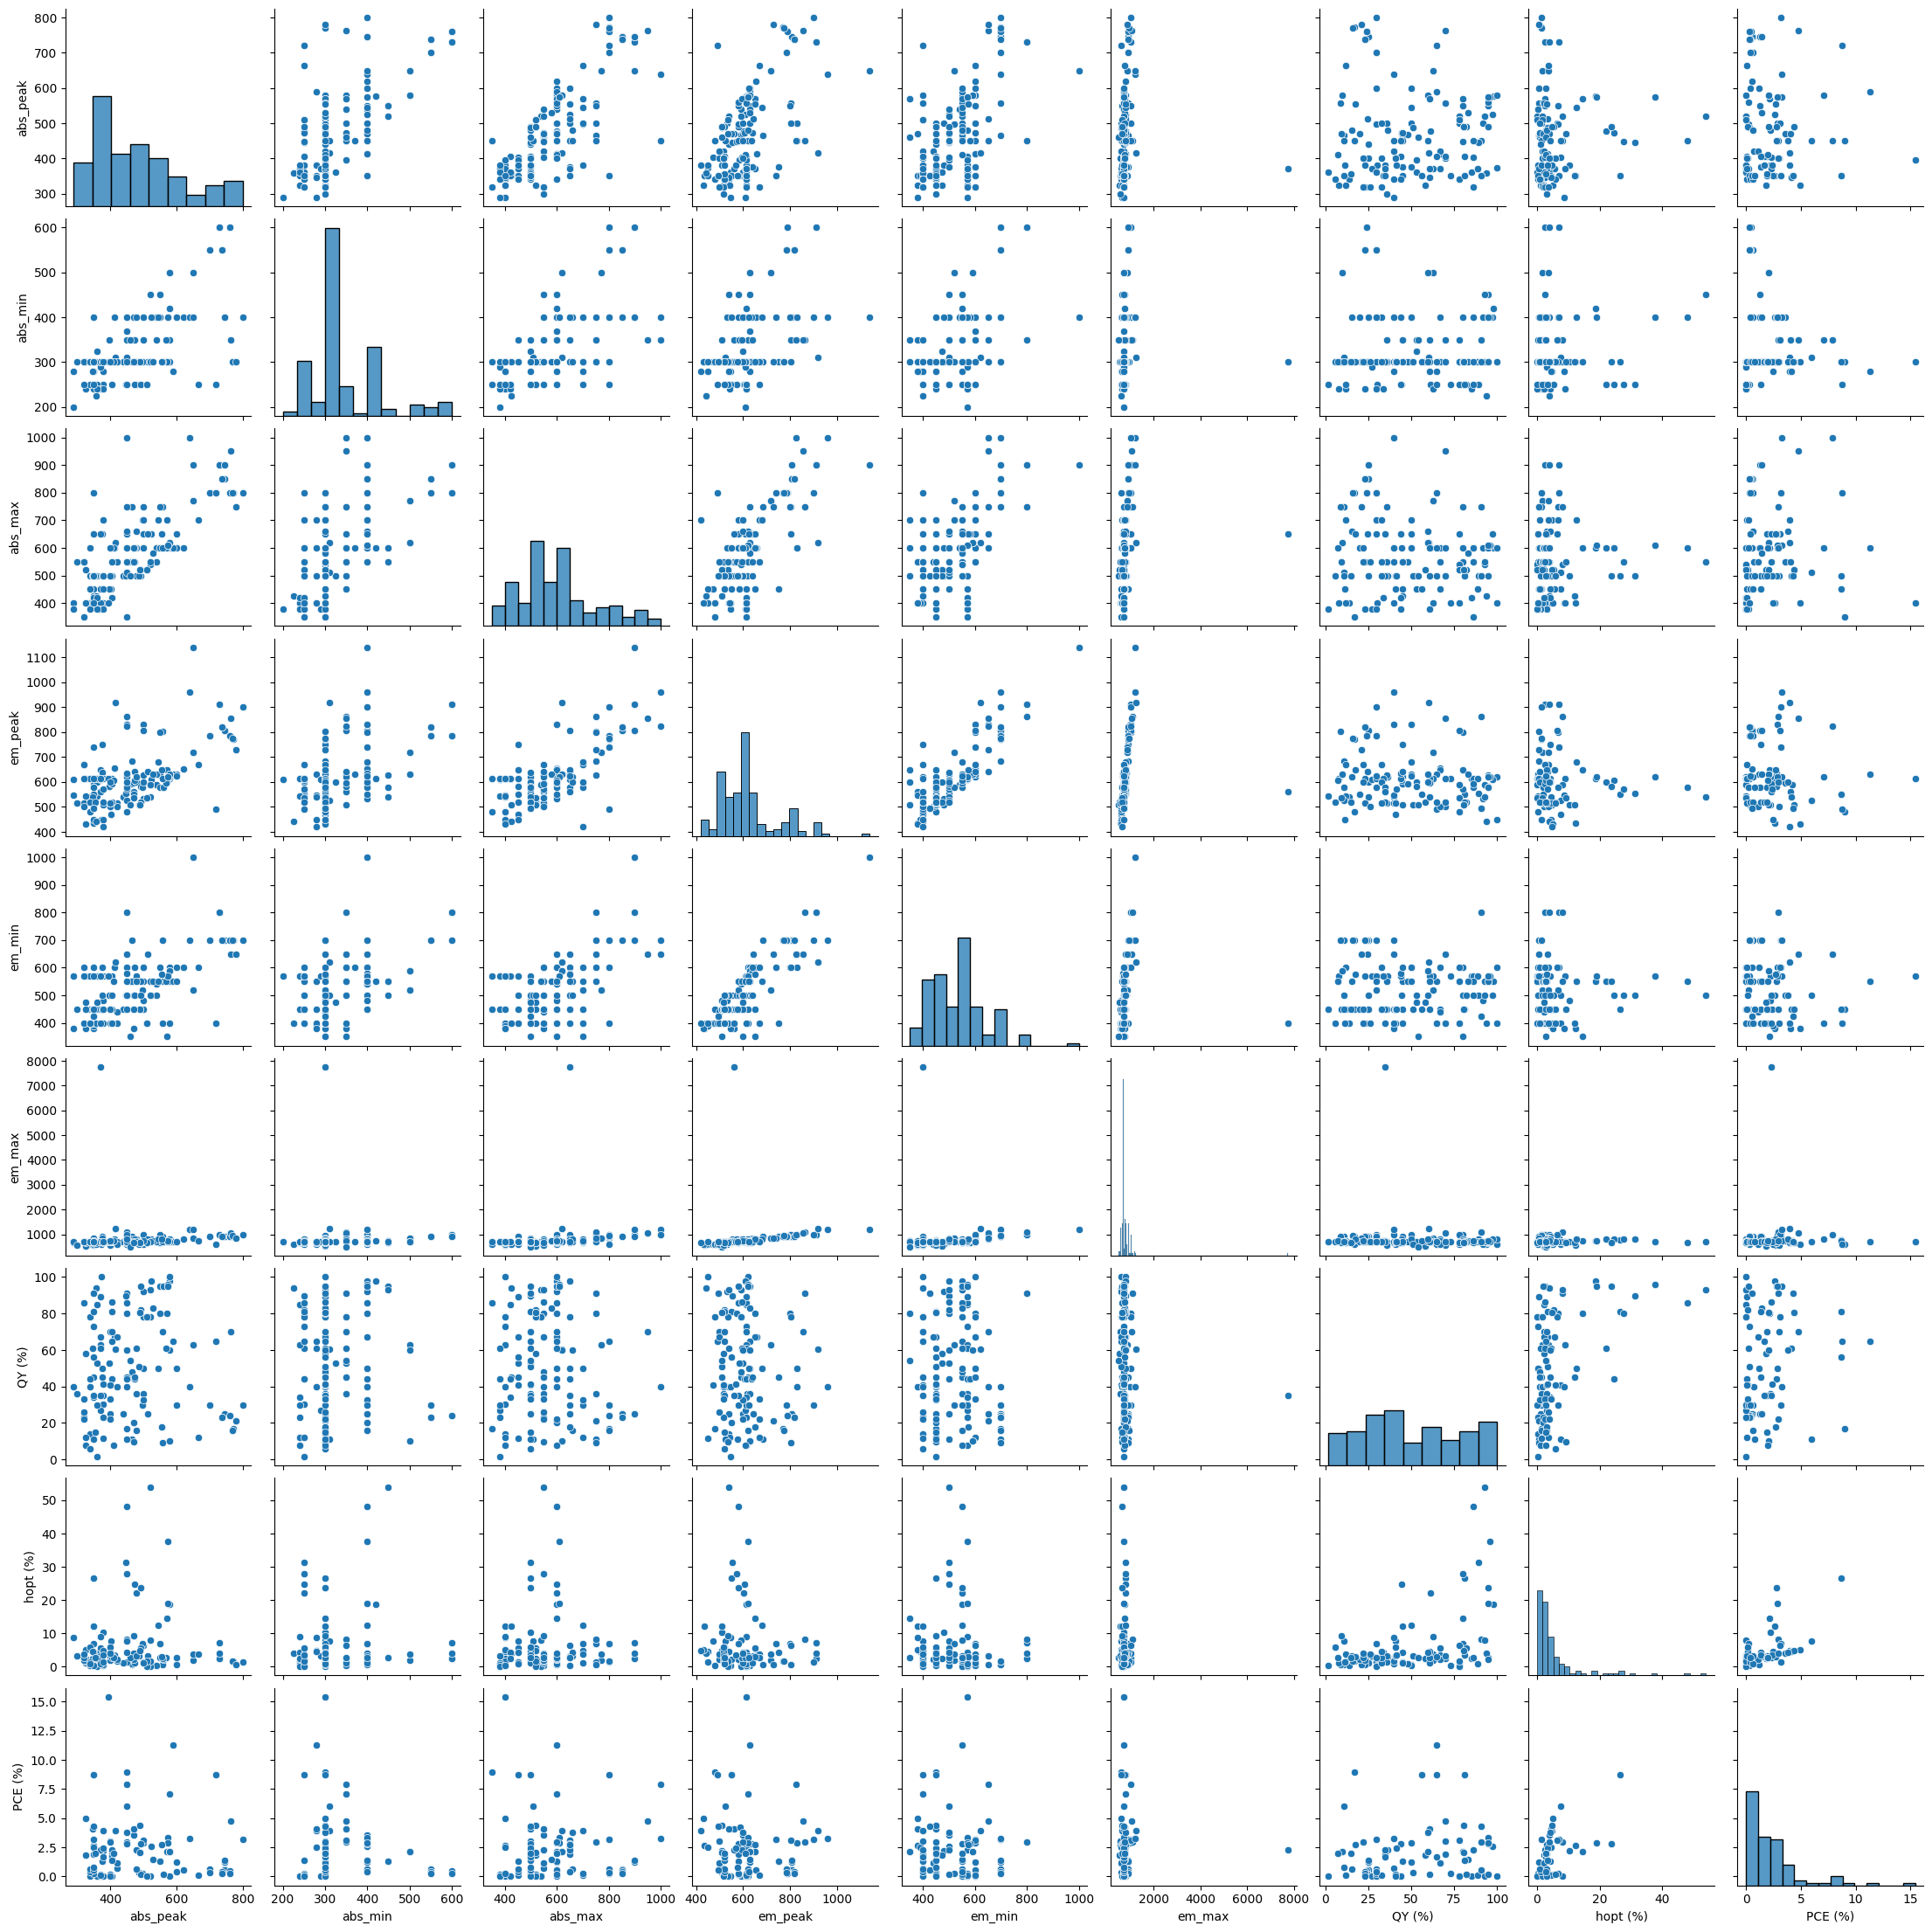

In [183]:
sns.pairplot(df.to_pandas())
plt.show()

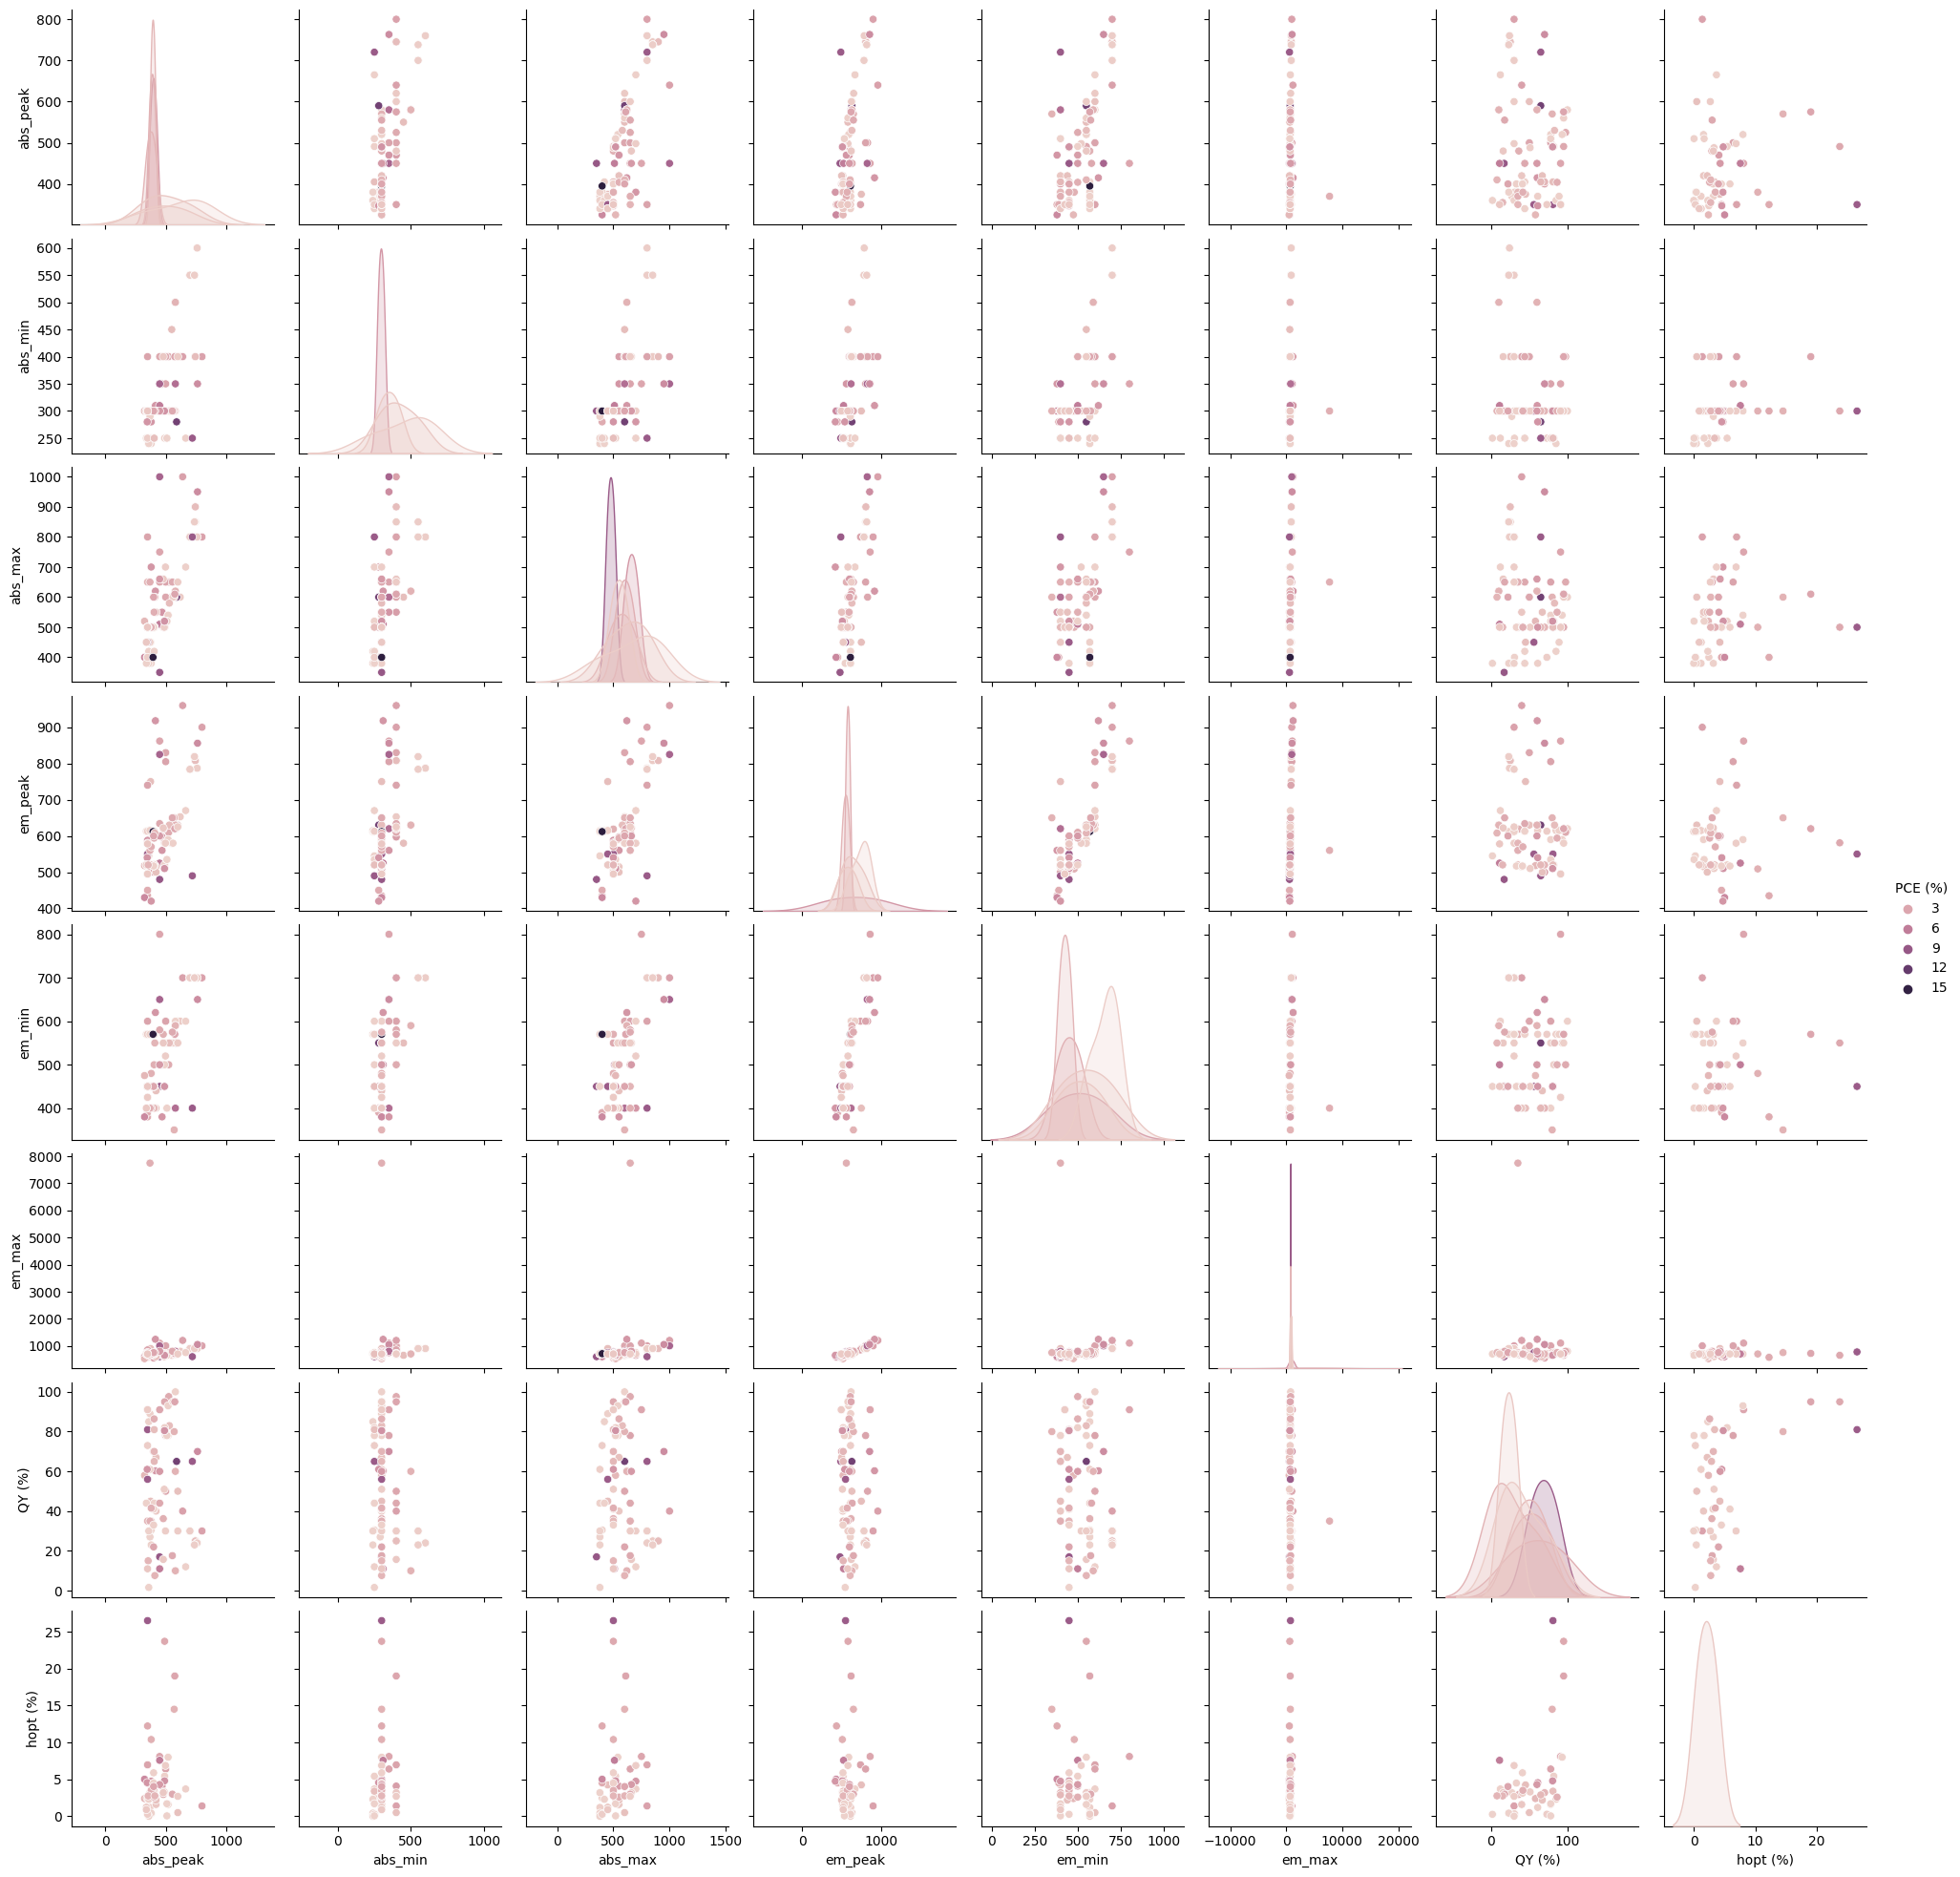

In [184]:
sns.pairplot(df.to_pandas(), hue='PCE (%)')
plt.show()

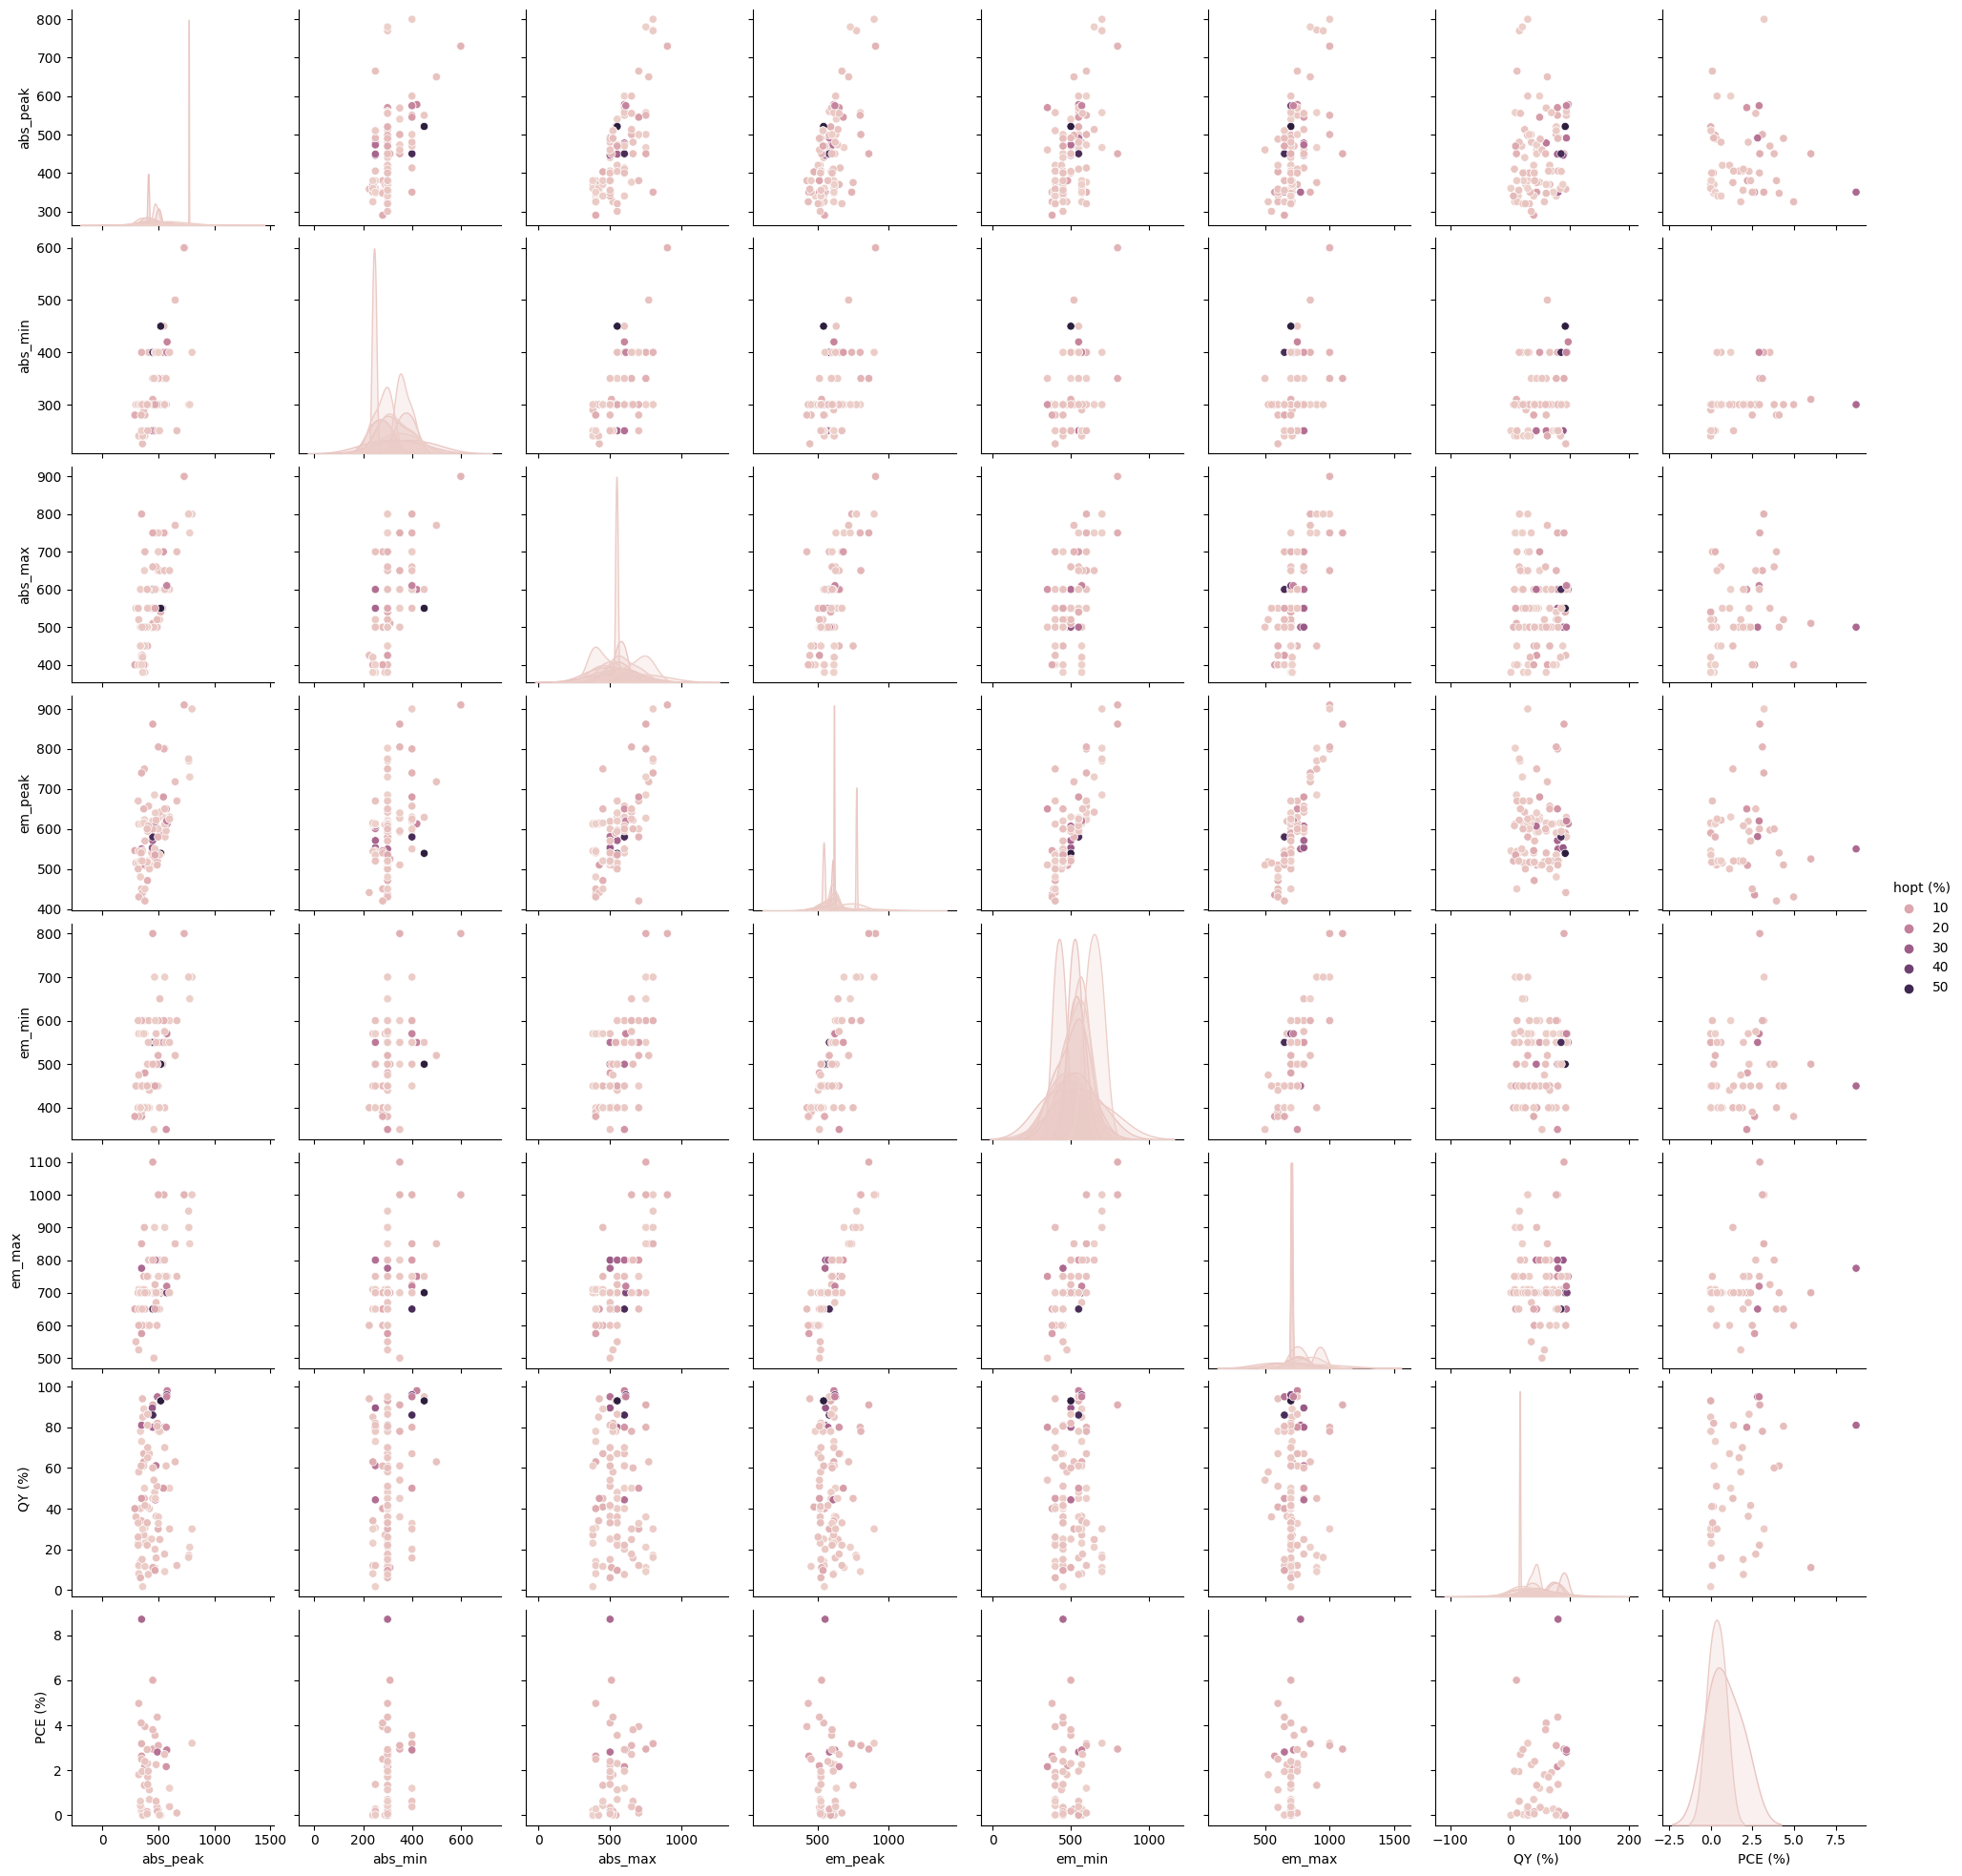

In [185]:
sns.pairplot(df.to_pandas(), hue='hopt (%)')
plt.show()

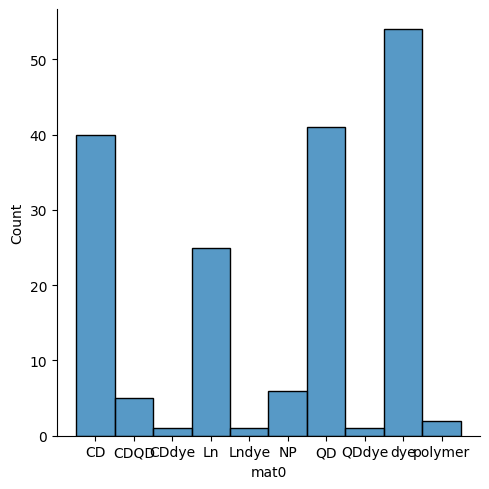

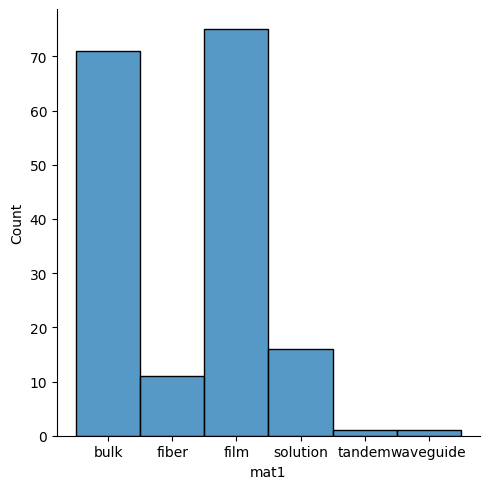

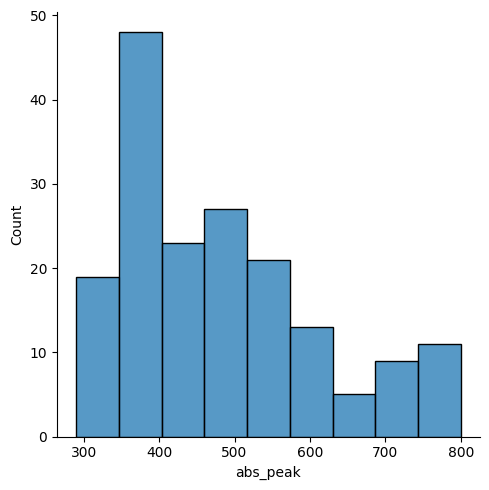

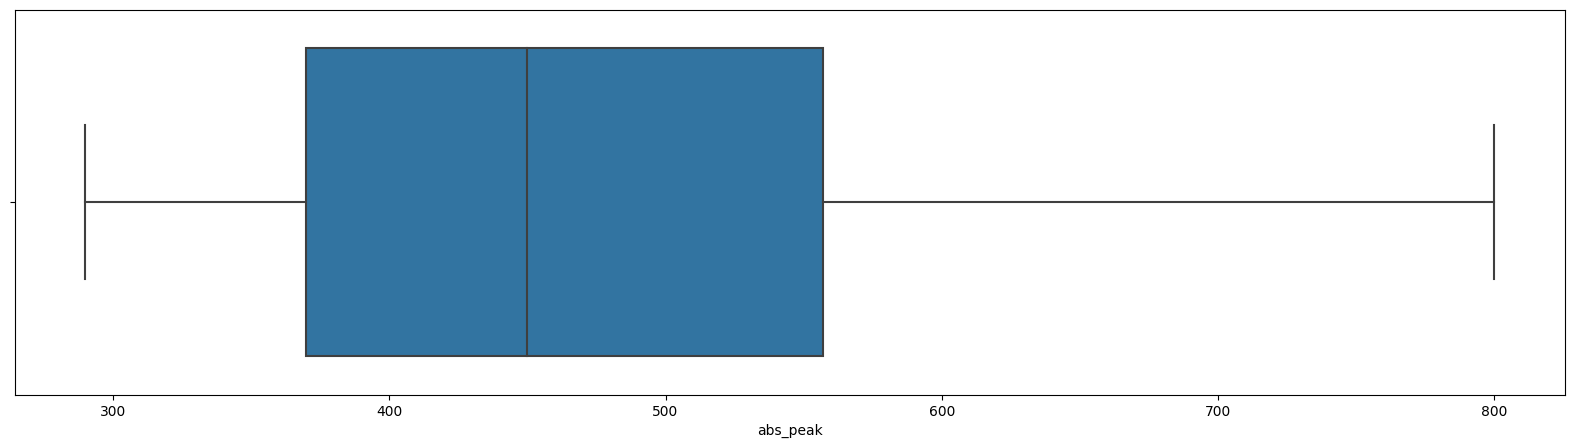

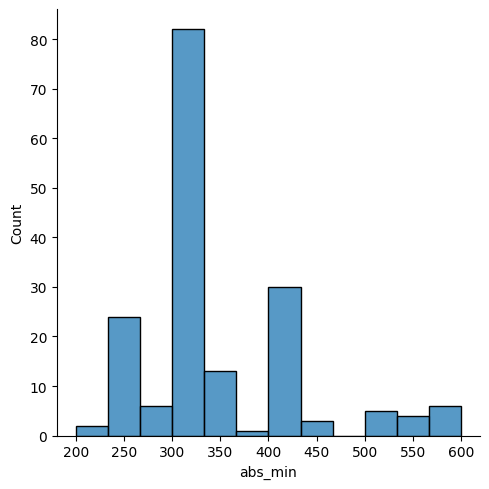

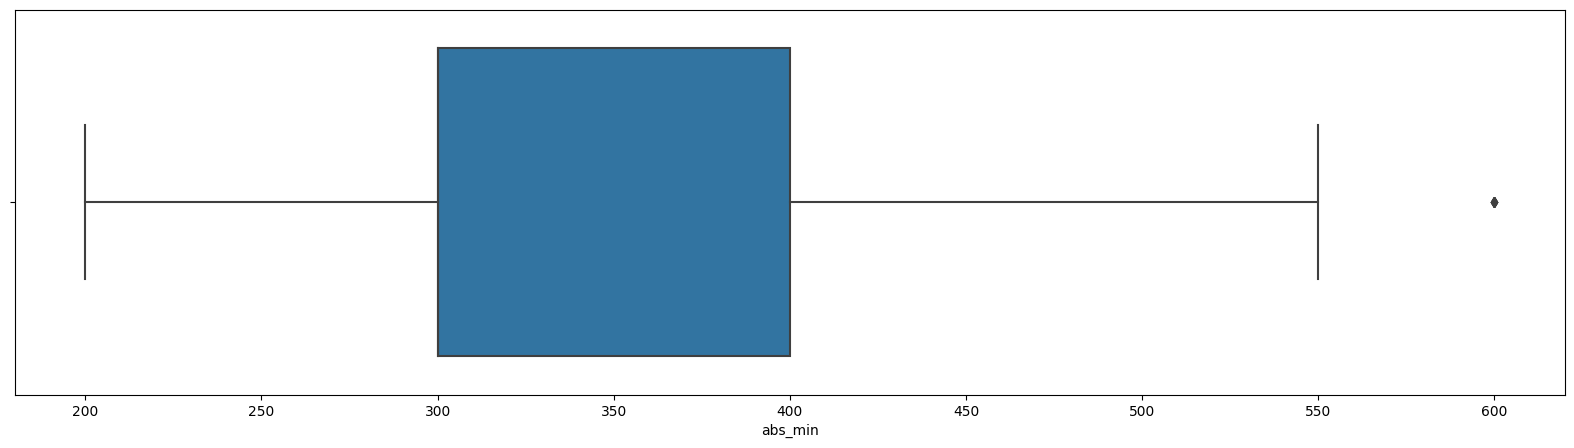

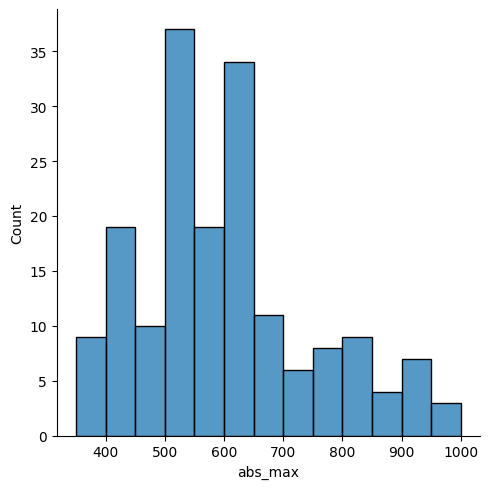

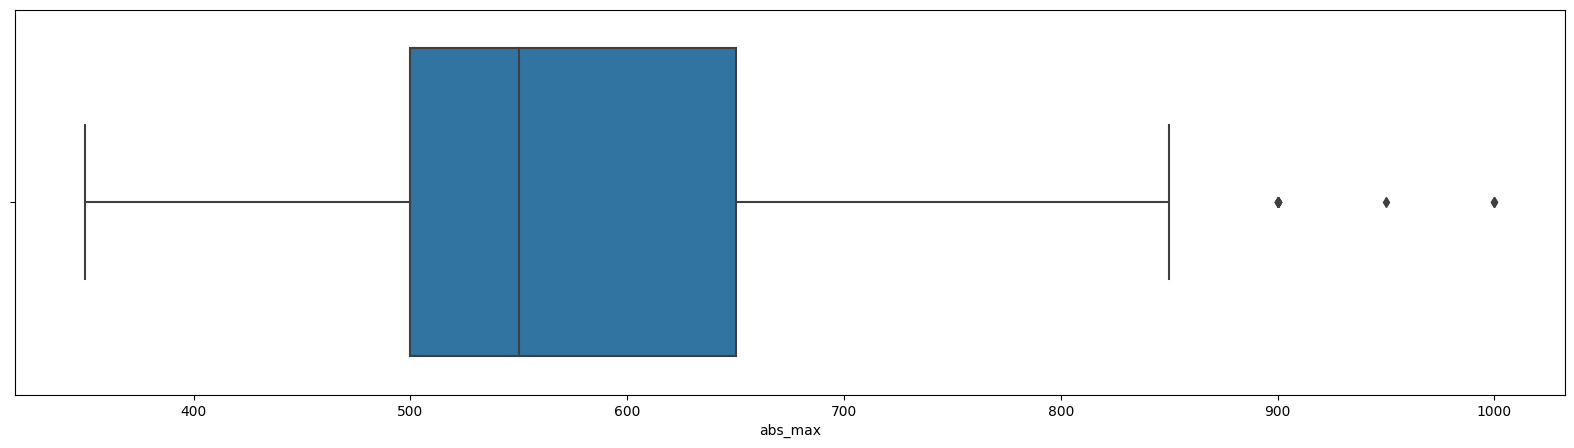

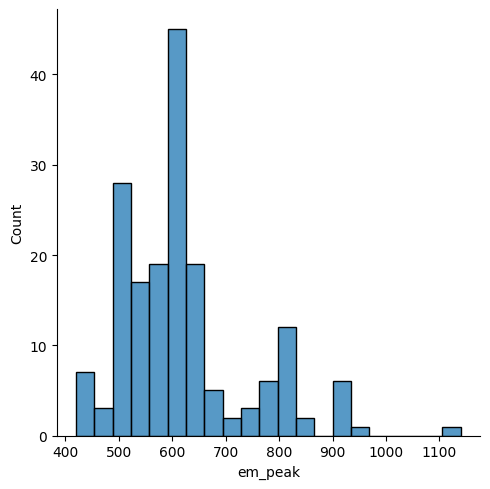

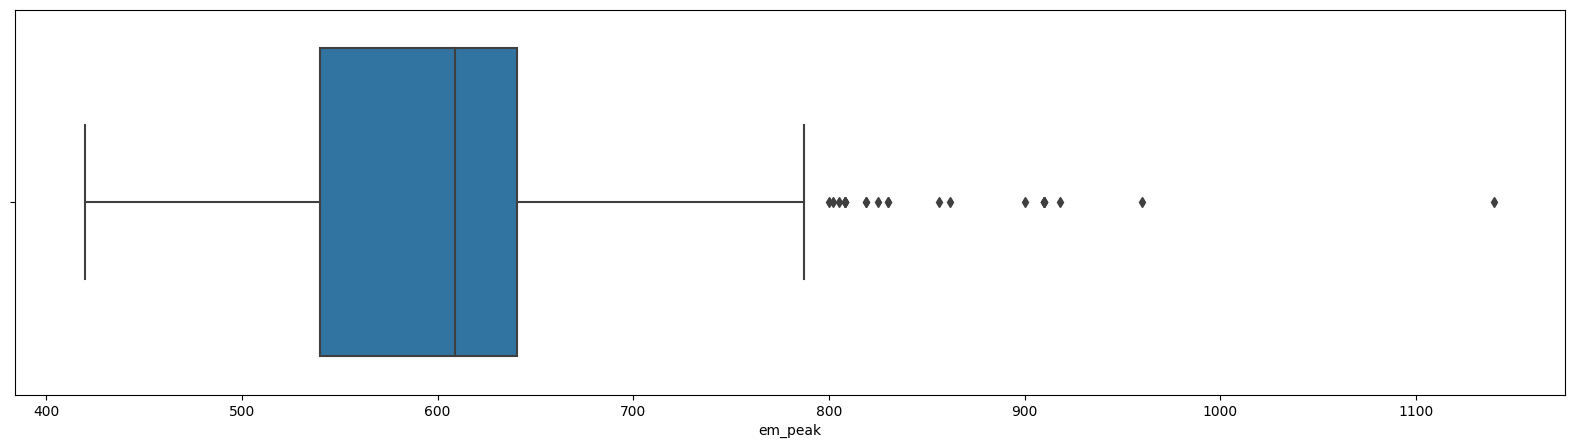

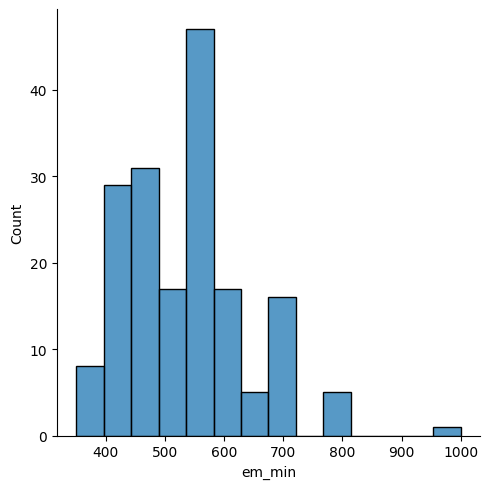

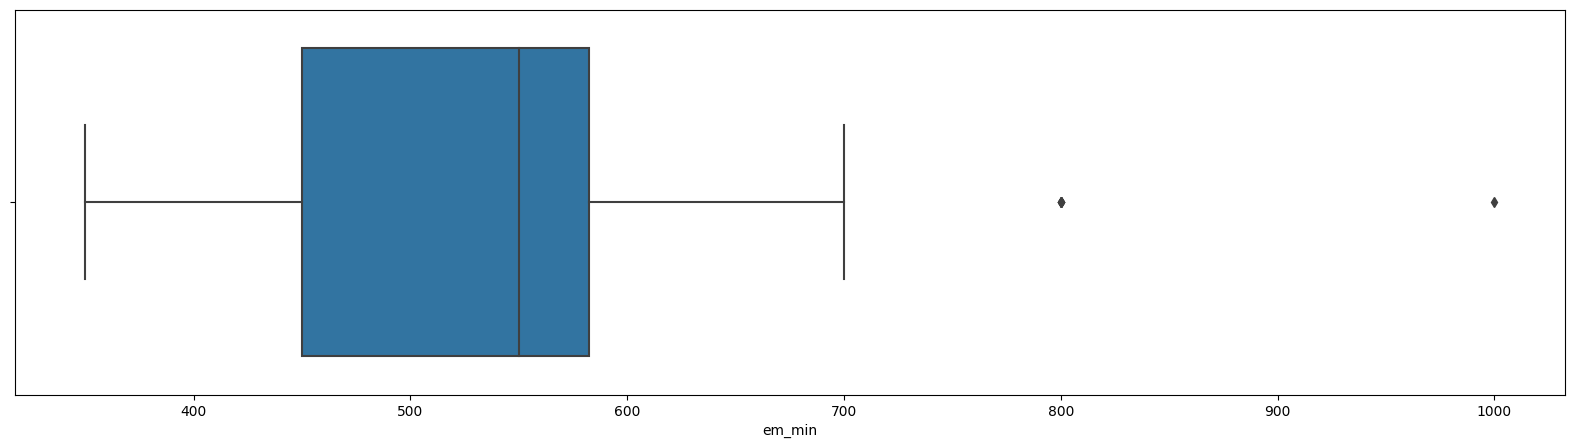

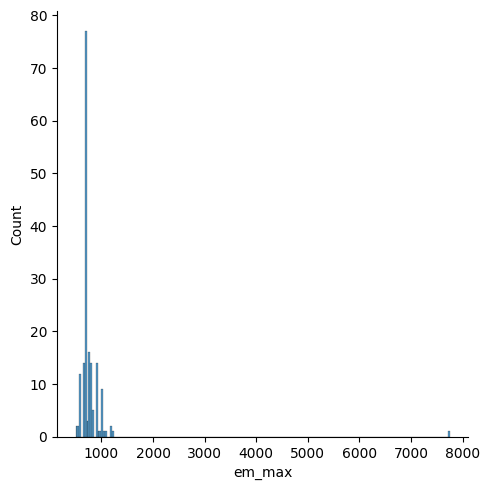

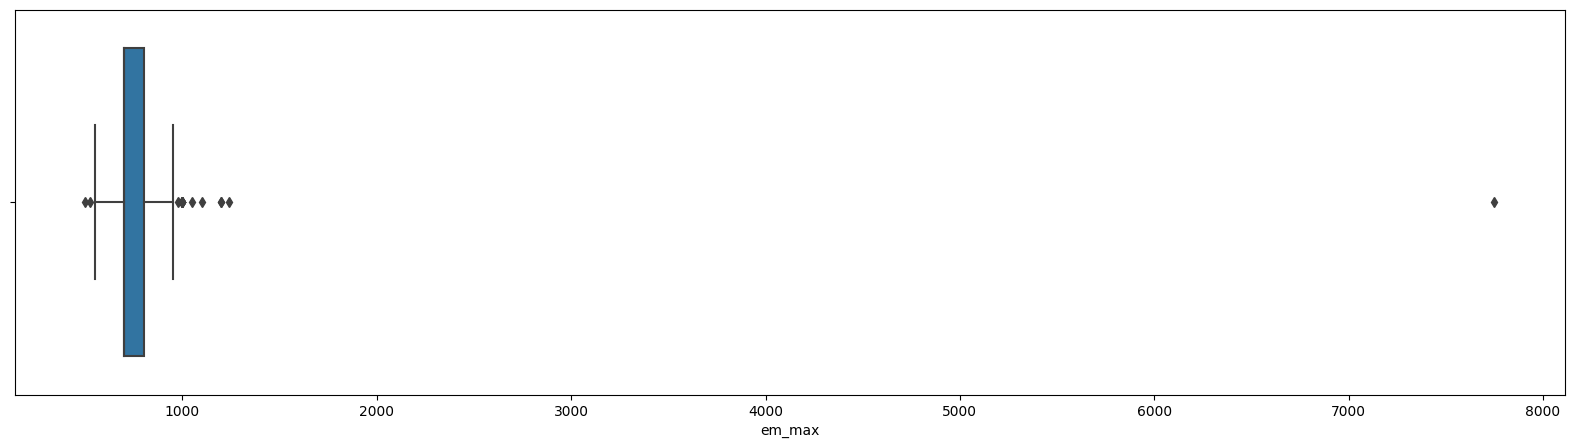

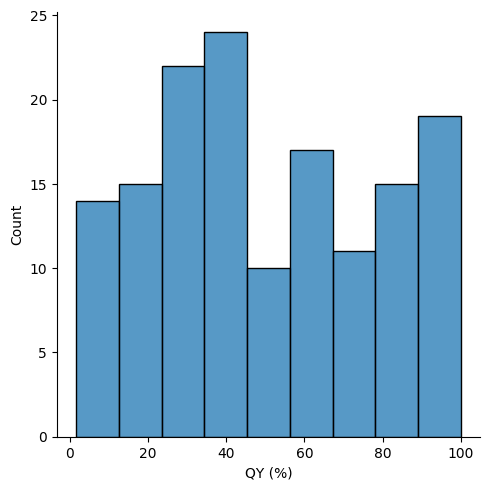

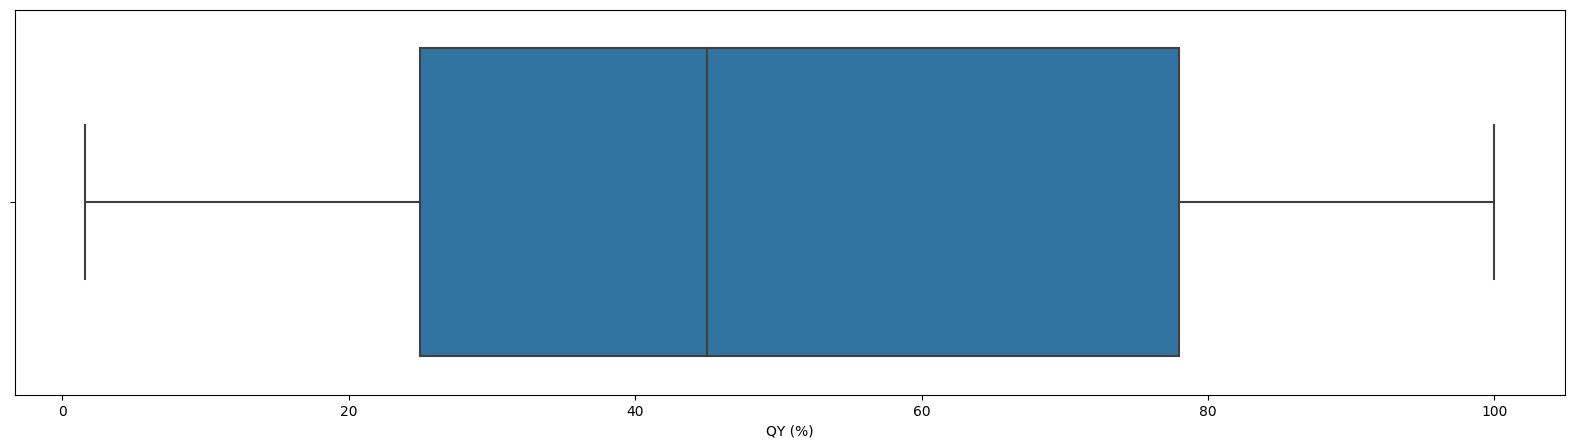

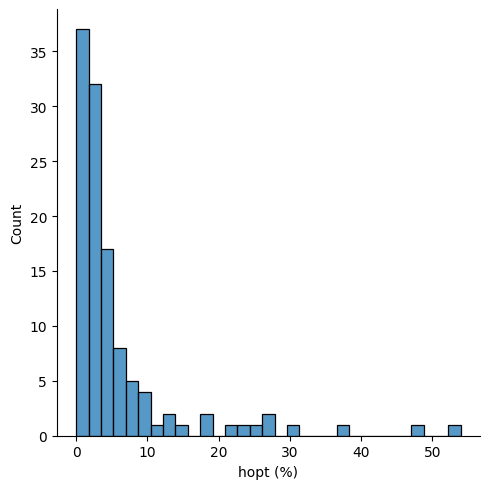

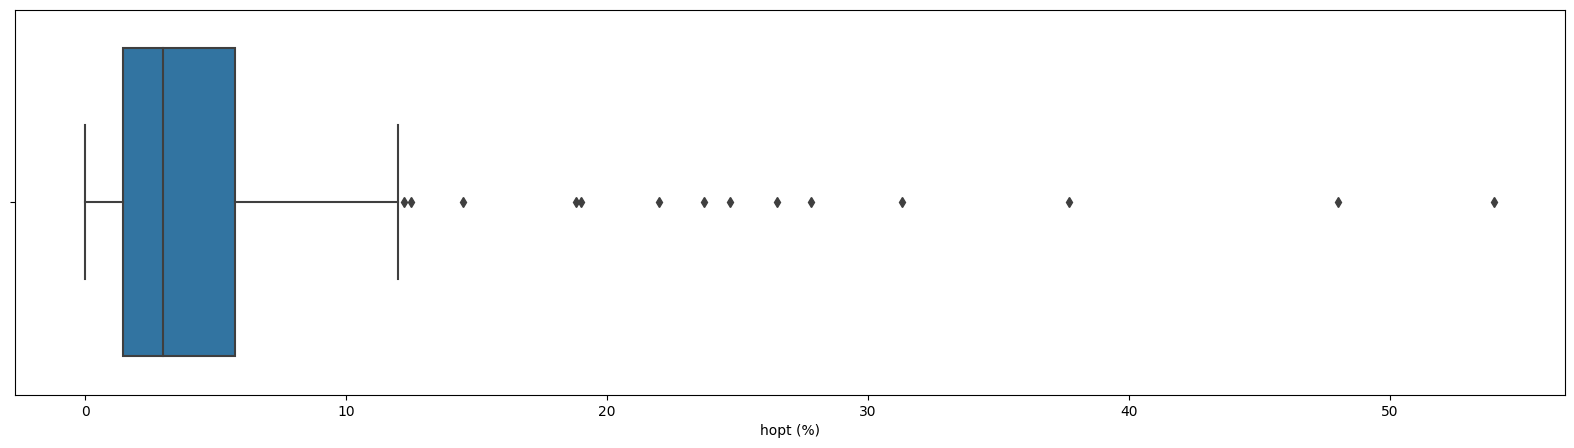

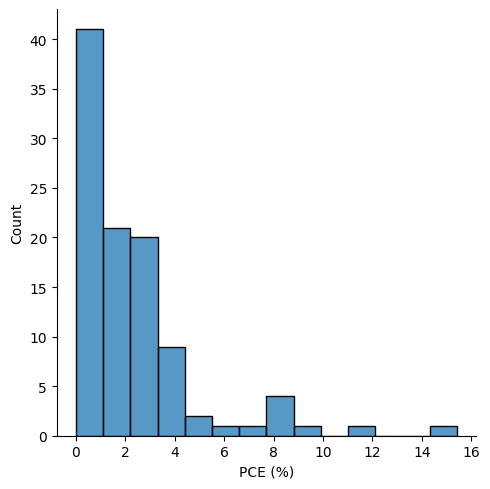

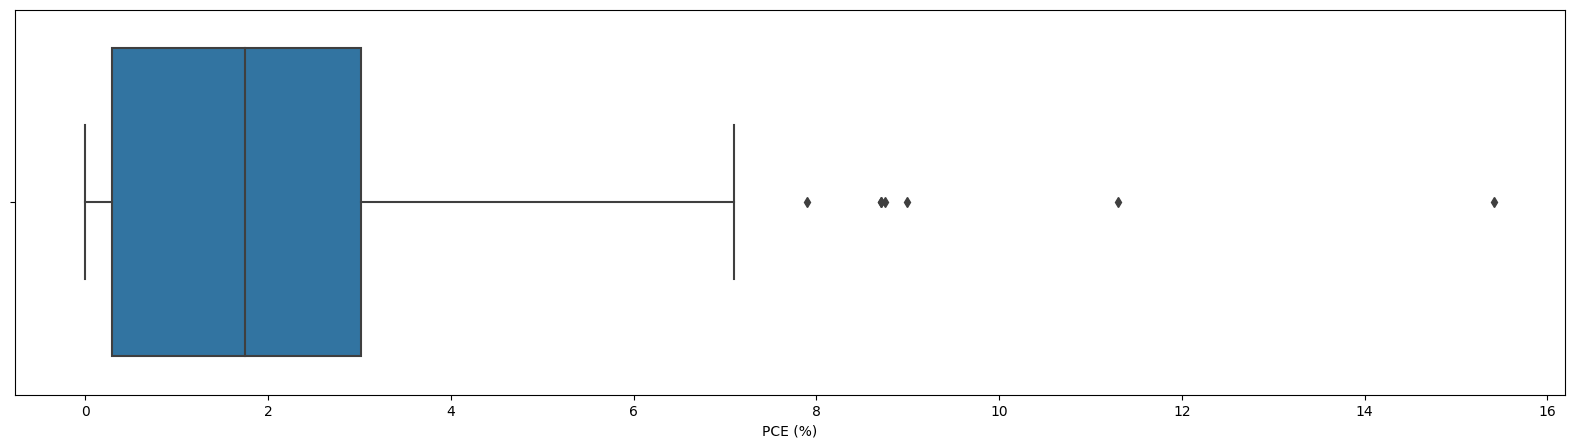

In [186]:
df_pandas = df.to_pandas()

categories = ['mat0', 'mat1']

for col in categories:
    df_pandas[col] = df_pandas[col].astype('category')

for col in df.get_columns():
    #print(f'{col.name}')
    sns.displot(data=df_pandas, x=col.name)
    plt.show()
    if col.name not in categories:
        sns.boxplot(data=df_pandas, x=col.name)
        plt.show()

In [187]:
total, _ = df.shape
for col in df.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

mat0  : 0%
mat1  : 1%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 16%
hopt (%): 33%
PCE (%): 42%


## PCE and hopt prediction

### Baseline (using only abs and em)

In [188]:
df_baseline_PCE = df.drop(['mat0', 'mat1', 'QY (%)', 'hopt (%)'])
df_baseline_PCE = df_baseline_PCE.drop_nulls()

total, _ = df_baseline_PCE.shape
for col in df_baseline_PCE.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_baseline_PCE

abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
PCE (%): 0%


shape: (102, 7)
┌──────────┬─────────┬─────────┬─────────┬────────┬────────┬─────────┐
│ abs_peak ┆ abs_min ┆ abs_max ┆ em_peak ┆ em_min ┆ em_max ┆ PCE (%) │
│ ---      ┆ ---     ┆ ---     ┆ ---     ┆ ---    ┆ ---    ┆ ---     │
│ i64      ┆ i64     ┆ i64     ┆ i64     ┆ i64    ┆ i64    ┆ f64     │
╞══════════╪═════════╪═════════╪═════════╪════════╪════════╪═════════╡
│ 800      ┆ 400     ┆ 800     ┆ 900     ┆ 700    ┆ 1000   ┆ 3.2     │
│ 600      ┆ 400     ┆ 600     ┆ 630     ┆ 600    ┆ 700    ┆ 1.2     │
│ 550      ┆ 450     ┆ 600     ┆ 580     ┆ 550    ┆ 650    ┆ 1.3     │
│ 470      ┆ 400     ┆ 550     ┆ 597     ┆ 500    ┆ 725    ┆ 3.55    │
│ ...      ┆ ...     ┆ ...     ┆ ...     ┆ ...    ┆ ...    ┆ ...     │
│ 600      ┆ 400     ┆ 650     ┆ 625     ┆ 550    ┆ 700    ┆ 0.38    │
│ 350      ┆ 300     ┆ 500     ┆ 495     ┆ 425    ┆ 700    ┆ 4.29    │
│ 350      ┆ 300     ┆ 500     ┆ 495     ┆ 425    ┆ 700    ┆ 0.55    │
│ 350      ┆ 300     ┆ 500     ┆ 578     ┆ 450    ┆ 700    ┆ 0.77    │
└──────────┴─────────┴─────────┴─────────┴────────┴────────┴─────────┘

In [189]:
df_baseline_hopt = df.drop(['mat0', 'mat1', 'QY (%)', 'PCE (%)'])
df_baseline_hopt = df_baseline_hopt.drop_nulls()

total, _ = df_baseline_hopt.shape
for col in df_baseline_hopt.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_baseline_hopt

abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
hopt (%): 0%


shape: (118, 7)
┌──────────┬─────────┬─────────┬─────────┬────────┬────────┬──────────┐
│ abs_peak ┆ abs_min ┆ abs_max ┆ em_peak ┆ em_min ┆ em_max ┆ hopt (%) │
│ ---      ┆ ---     ┆ ---     ┆ ---     ┆ ---    ┆ ---    ┆ ---      │
│ i64      ┆ i64     ┆ i64     ┆ i64     ┆ i64    ┆ i64    ┆ f64      │
╞══════════╪═════════╪═════════╪═════════╪════════╪════════╪══════════╡
│ 578      ┆ 420     ┆ 600     ┆ 613     ┆ 550    ┆ 750    ┆ 18.8     │
│ 730      ┆ 600     ┆ 900     ┆ 910     ┆ 800    ┆ 1000   ┆ 2.5      │
│ 730      ┆ 600     ┆ 900     ┆ 910     ┆ 800    ┆ 1000   ┆ 2.5      │
│ 730      ┆ 600     ┆ 900     ┆ 910     ┆ 800    ┆ 1000   ┆ 4.0      │
│ ...      ┆ ...     ┆ ...     ┆ ...     ┆ ...    ┆ ...    ┆ ...      │
│ 355      ┆ 300     ┆ 500     ┆ 520     ┆ 450    ┆ 650    ┆ 2.76     │
│ 410      ┆ 300     ┆ 600     ┆ 608     ┆ 550    ┆ 750    ┆ 2.77     │
│ 400      ┆ 300     ┆ 600     ┆ 600     ┆ 450    ┆ 750    ┆ 4.03     │
│ 600      ┆ 400     ┆ 650     ┆ 625     ┆ 550    ┆ 700    ┆ 2.7      │
└──────────┴─────────┴─────────┴─────────┴────────┴────────┴──────────┘

In [190]:
models = [('Linear Regression', LinearRegression()),
          ('K Neighbors Regressor', KNeighborsRegressor()),
          ('Lasso Regression', Lasso(random_state=42)),
          ('Support Vector Regressor', SVR(kernel='linear')),
          ('ANN', MLPRegressor(hidden_layer_sizes=(8,), max_iter=20000, random_state=42, learning_rate='adaptive')),
          ('Random Forest Regressor', RandomForestRegressor(random_state=42)),
          ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42))]

PCE
Linear Regression             : 2.9835943614837697
K Neighbors Regressor         : 2.473888
Lasso Regression              : 2.922520726967875
Support Vector Regressor      : 2.4562955319867954
ANN                           : 5.787923463360214
Random Forest Regressor       : 2.2187780021288517
Gradient Boosting Regressor   : 2.2565858136169488

Linear Regression             


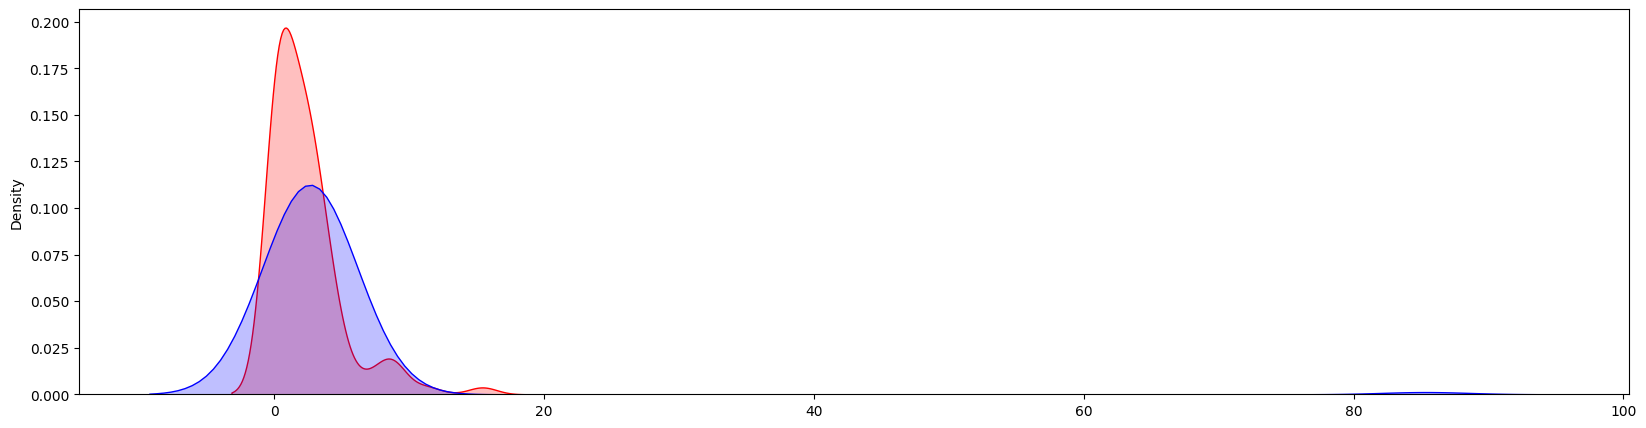

K Neighbors Regressor         


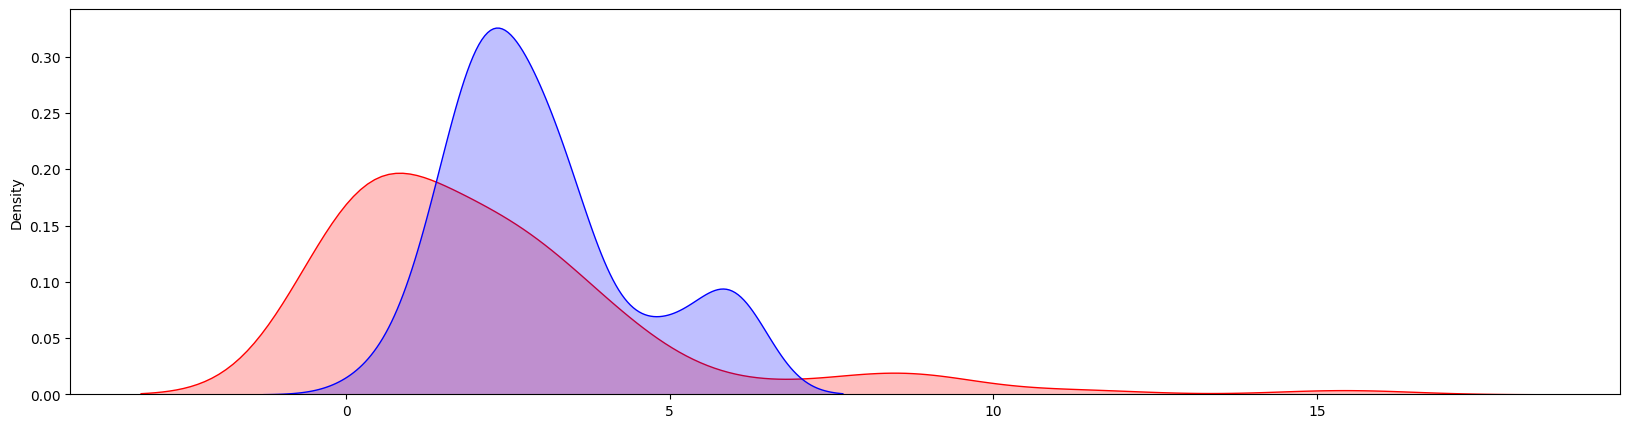

Lasso Regression              


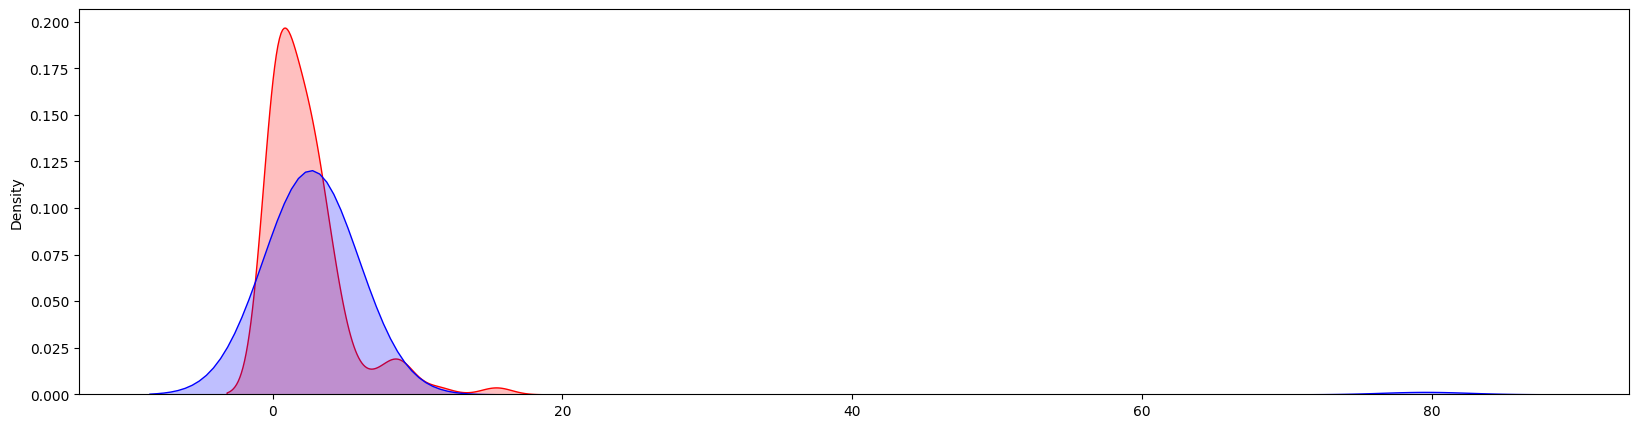

Support Vector Regressor      


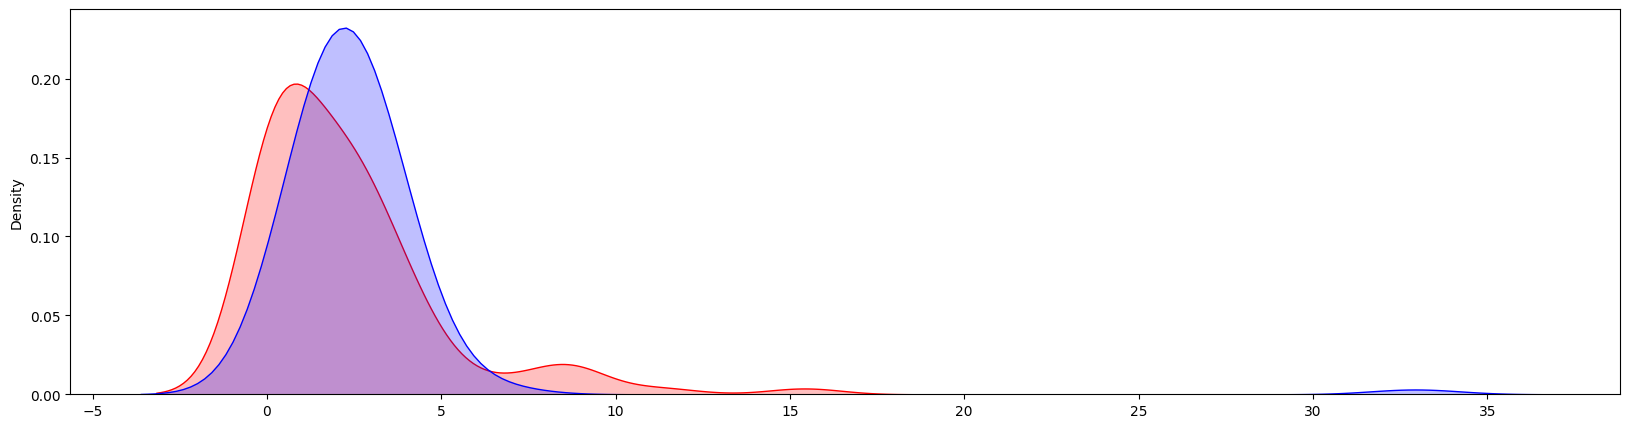

ANN                           


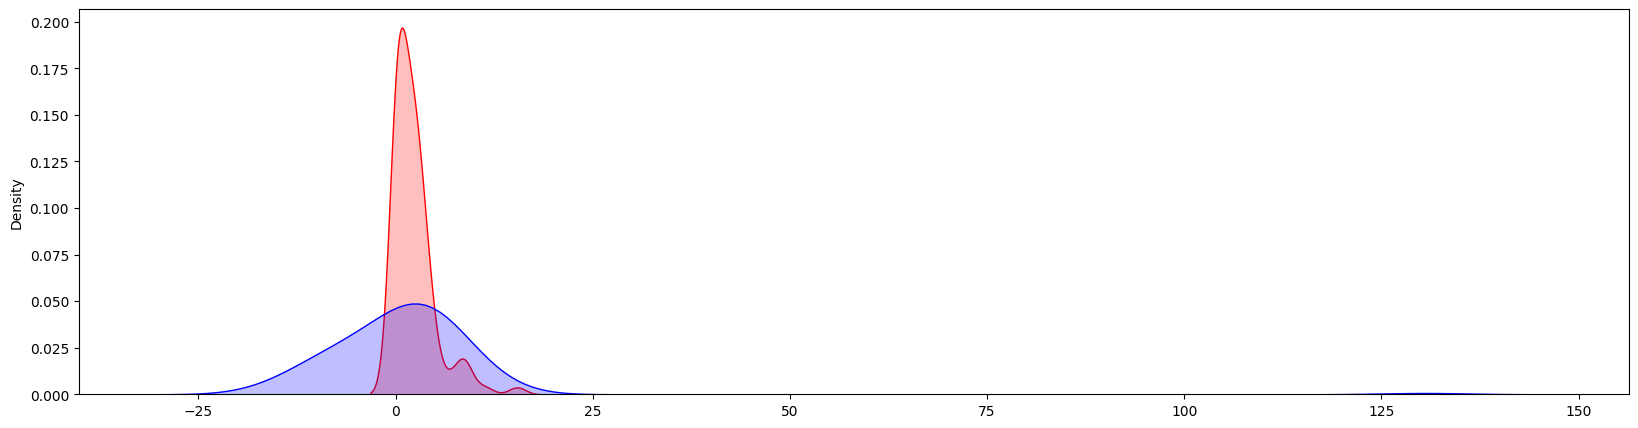

Random Forest Regressor       


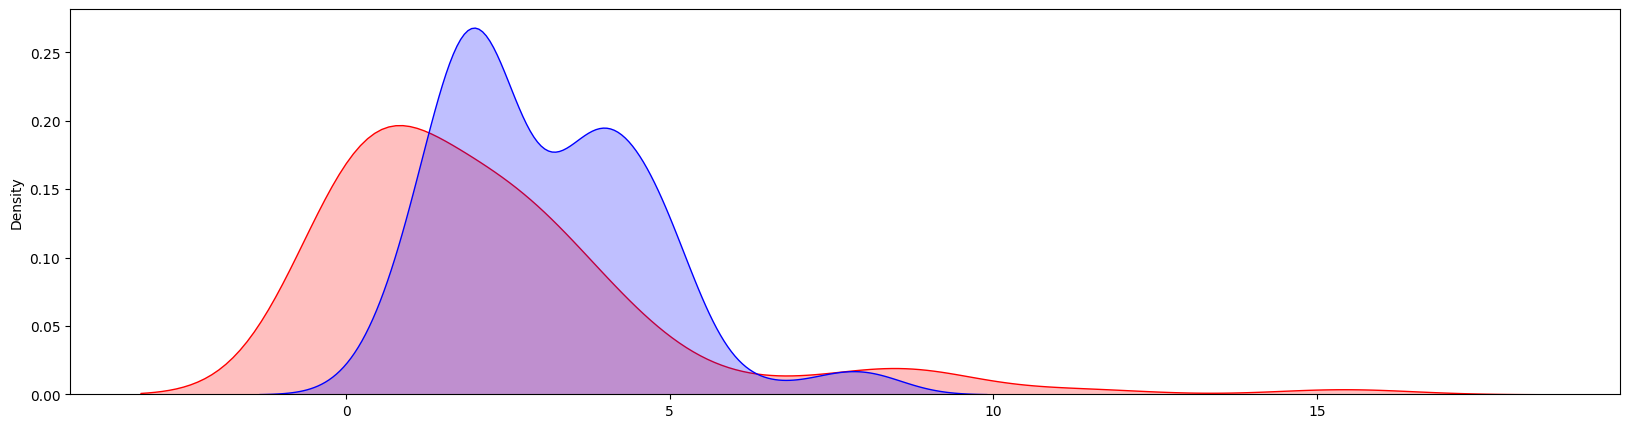

Gradient Boosting Regressor   


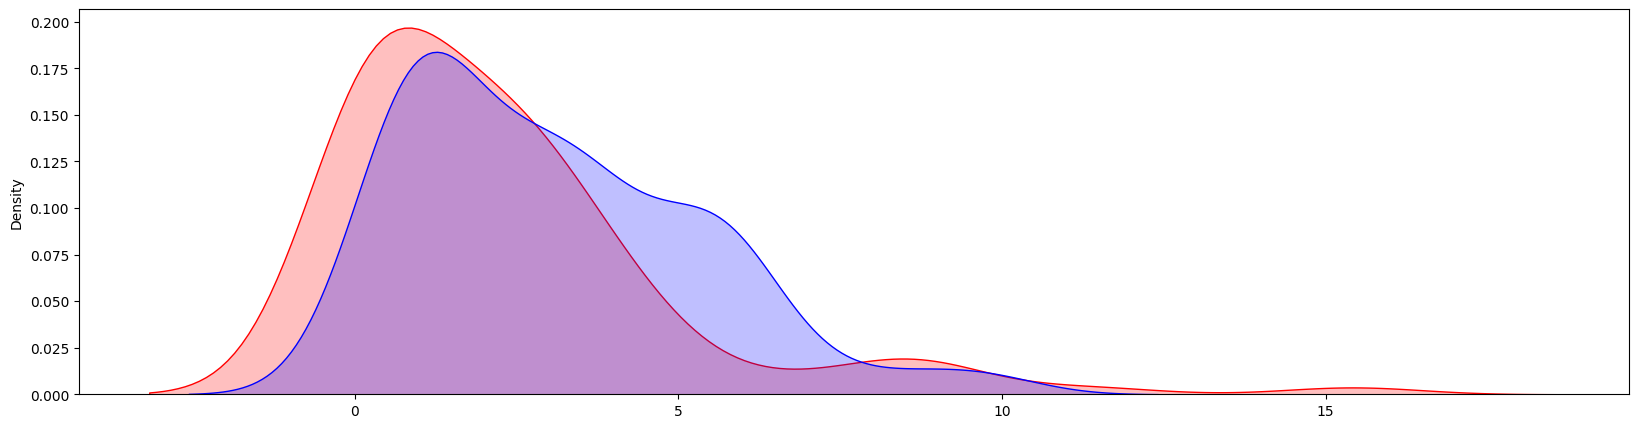

In [191]:
# Get Output variables
PCE = df_baseline_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_baseline_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
for m in models:
    scores = -1 * cross_val_score(m[1], X, y_PCE, cv=3, scoring='neg_mean_absolute_error')
    print(f'{m[0]:30}: {scores.mean()}')
print()

for m in models:
    y_pred = cross_val_predict(m[1], X, y_PCE, cv=3)
    print(f'{m[0]:30}')
    fig = sns.kdeplot(y_PCE, fill=True, color="r")
    fig = sns.kdeplot(y_pred, fill=True, color="b")
    plt.show()

hopt
Linear Regression             : 7.975082857762582
K Neighbors Regressor         : 6.243512820512822
Lasso Regression              : 7.946968846523536
Support Vector Regressor      : 4.951628251302204
ANN                           : 6.111774051829186
Random Forest Regressor       : 7.714546373066746
Gradient Boosting Regressor   : 8.107472946449226

Linear Regression             


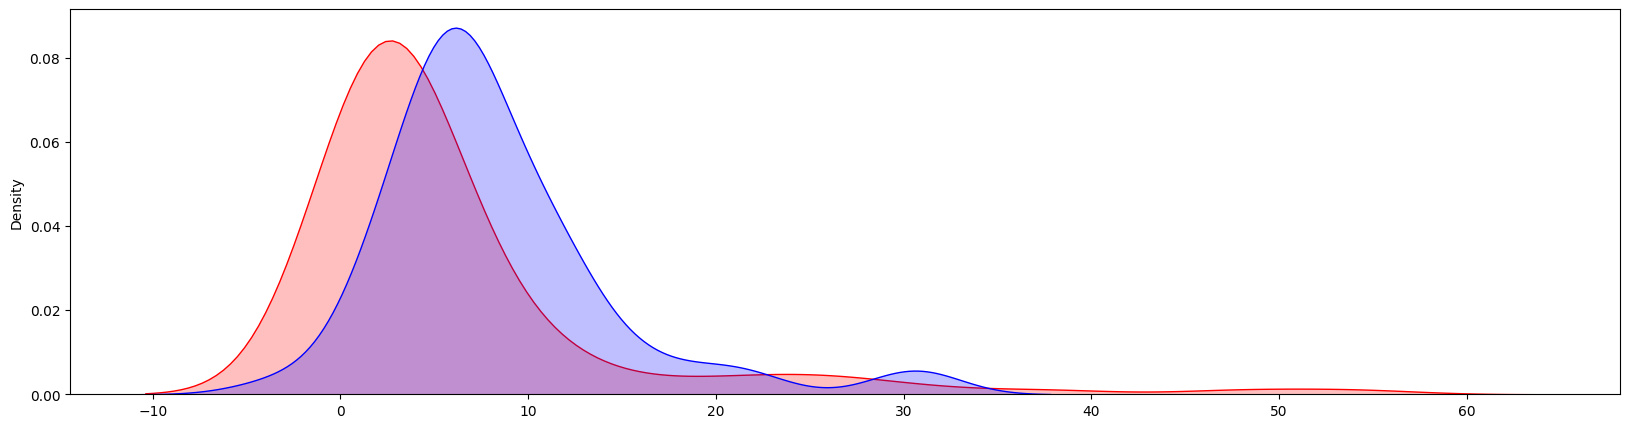

K Neighbors Regressor         


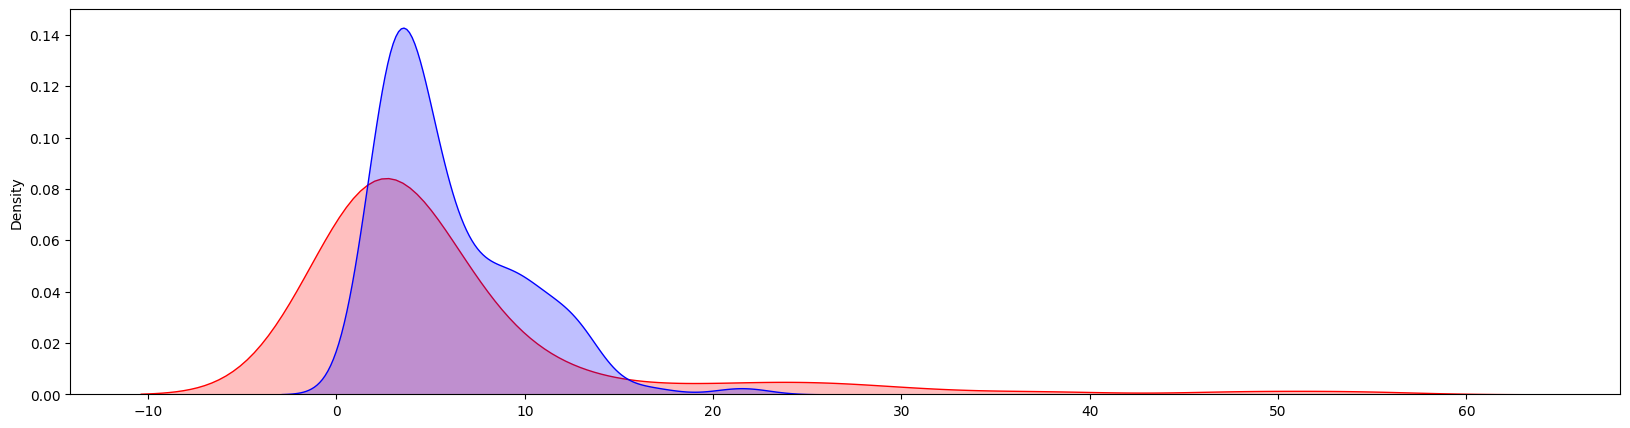

Lasso Regression              


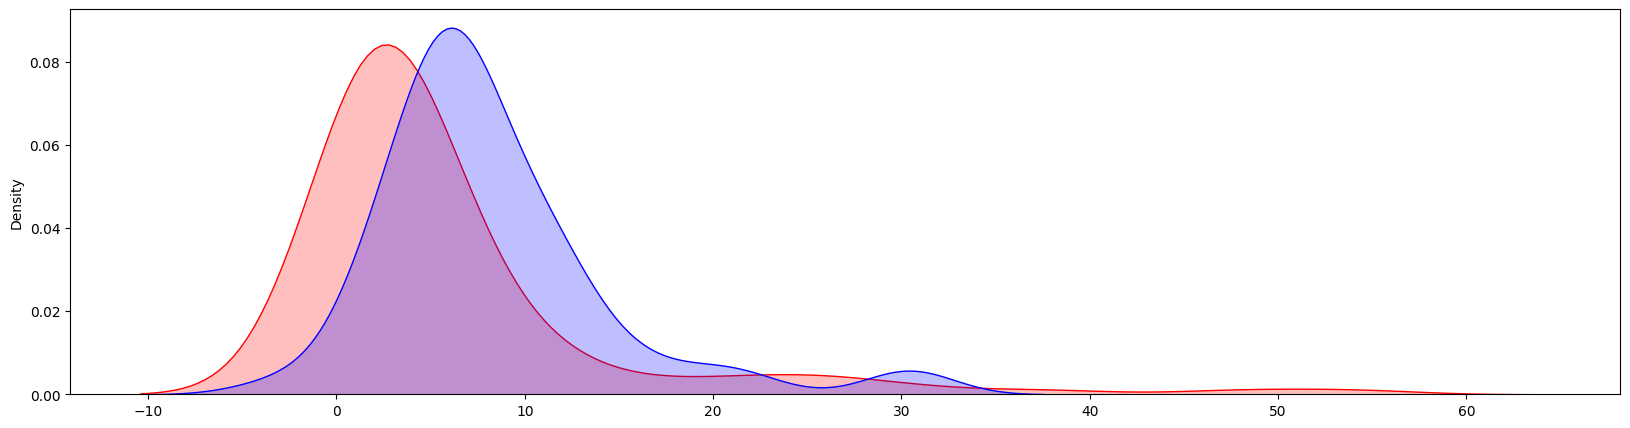

Support Vector Regressor      


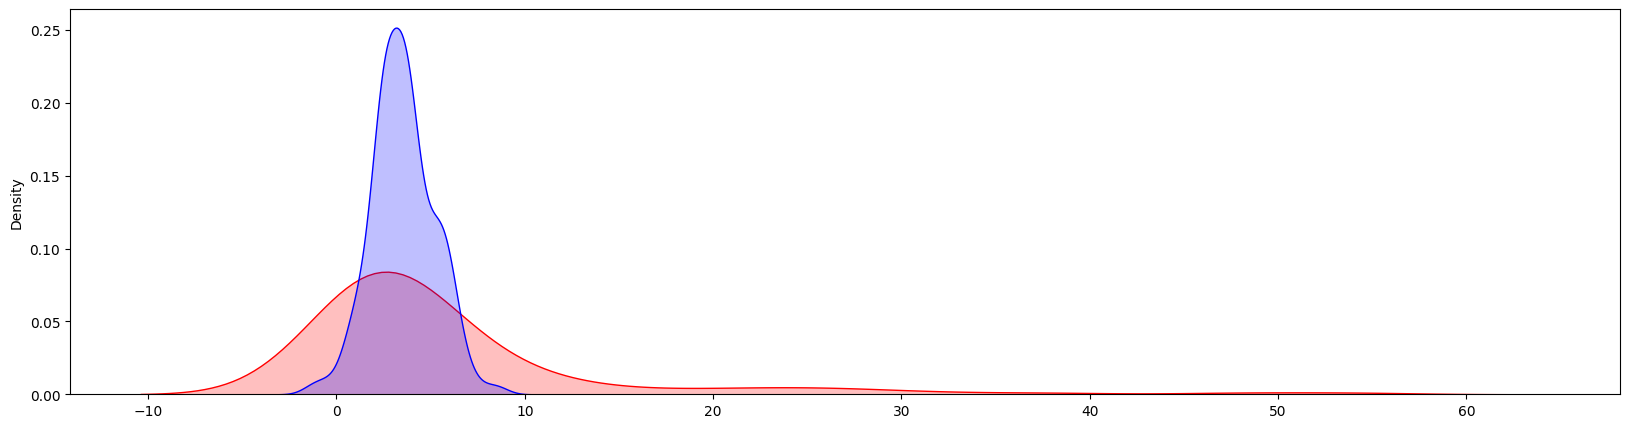

ANN                           


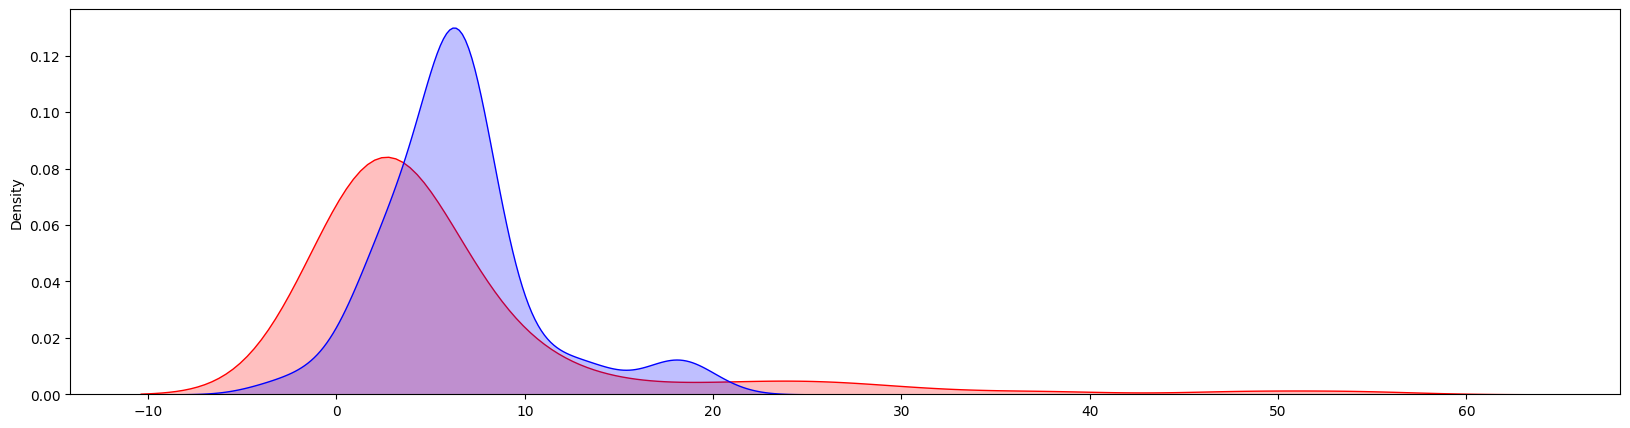

Random Forest Regressor       


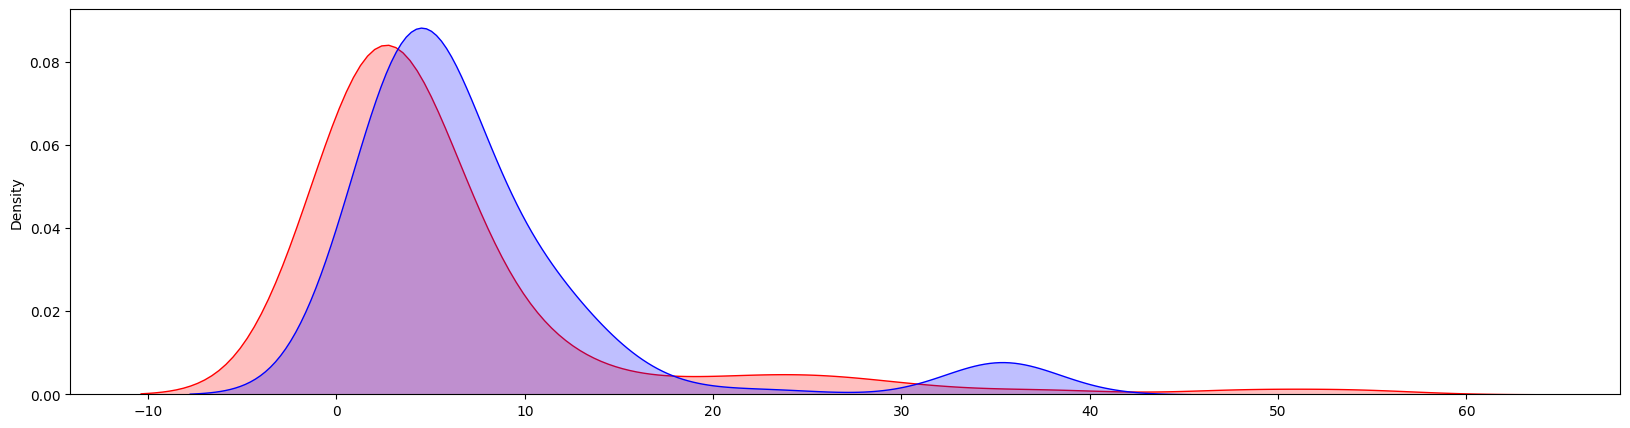

Gradient Boosting Regressor   


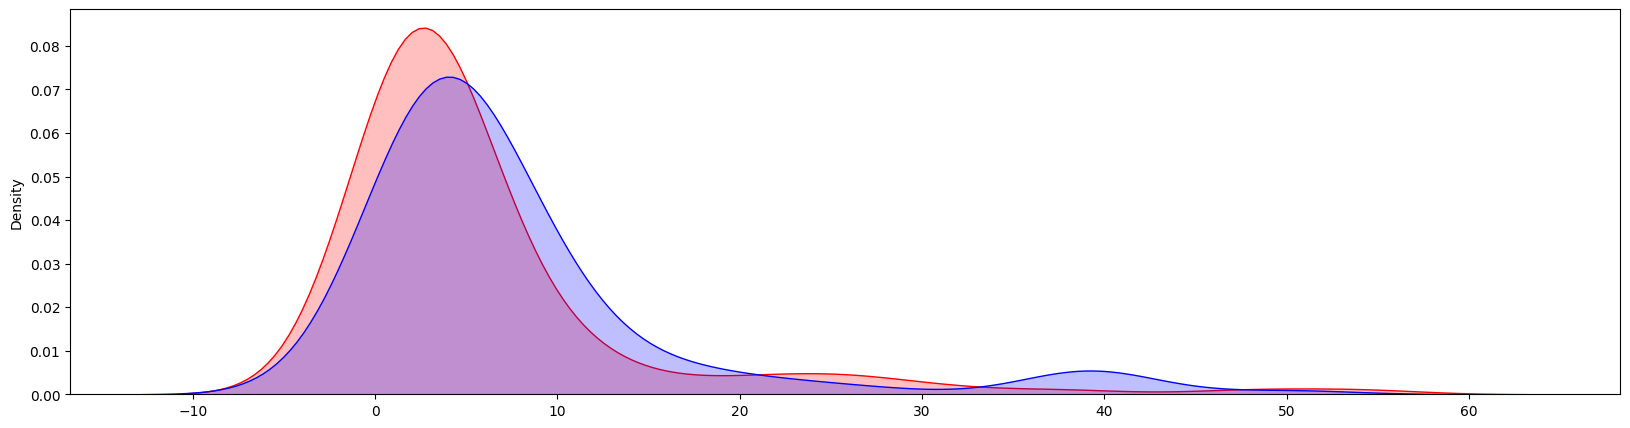

In [192]:
# Get Output variables
hopt = df_baseline_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_baseline_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()


## hopt
print(f'hopt')
for m in models:
    scores = -1 * cross_val_score(m[1], X, y_hopt, cv=3, scoring='neg_mean_absolute_error')
    print(f'{m[0]:30}: {scores.mean()}')
print()

for m in models:
    y_pred = cross_val_predict(m[1], X, y_hopt, cv=3)
    print(f'{m[0]:30}')
    fig = sns.kdeplot(y_hopt, fill=True, color="r")
    fig = sns.kdeplot(y_pred, fill=True, color="b")
    plt.show()

### Adding QY as a feature

In [193]:
df_02_PCE = df.drop(['mat0', 'mat1', 'hopt (%)'])
df_02_PCE = df_02_PCE.drop_nulls()

total, _ = df_02_PCE.shape
for col in df_02_PCE.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_02_PCE

abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


shape: (85, 8)
┌──────────┬─────────┬─────────┬─────────┬────────┬────────┬────────┬─────────┐
│ abs_peak ┆ abs_min ┆ abs_max ┆ em_peak ┆ em_min ┆ em_max ┆ QY (%) ┆ PCE (%) │
│ ---      ┆ ---     ┆ ---     ┆ ---     ┆ ---    ┆ ---    ┆ ---    ┆ ---     │
│ i64      ┆ i64     ┆ i64     ┆ i64     ┆ i64    ┆ i64    ┆ f64    ┆ f64     │
╞══════════╪═════════╪═════════╪═════════╪════════╪════════╪════════╪═════════╡
│ 800      ┆ 400     ┆ 800     ┆ 900     ┆ 700    ┆ 1000   ┆ 30.0   ┆ 3.2     │
│ 600      ┆ 400     ┆ 600     ┆ 630     ┆ 600    ┆ 700    ┆ 50.0   ┆ 1.2     │
│ 580      ┆ 300     ┆ 600     ┆ 620     ┆ 600    ┆ 800    ┆ 100.0  ┆ 0.0018  │
│ 745      ┆ 400     ┆ 850     ┆ 808     ┆ 700    ┆ 900    ┆ 25.0   ┆ 0.61    │
│ ...      ┆ ...     ┆ ...     ┆ ...     ┆ ...    ┆ ...    ┆ ...    ┆ ...     │
│ 600      ┆ 400     ┆ 650     ┆ 625     ┆ 550    ┆ 700    ┆ 30.0   ┆ 0.38    │
│ 350      ┆ 300     ┆ 500     ┆ 495     ┆ 425    ┆ 700    ┆ 91.0   ┆ 4.29    │
│ 350      ┆ 300     ┆ 500     ┆ 495     ┆ 425    ┆ 700    ┆ 91.0   ┆ 0.55    │
│ 350      ┆ 300     ┆ 500     ┆ 578     ┆ 450    ┆ 700    ┆ 11.0   ┆ 0.77    │
└──────────┴─────────┴─────────┴─────────┴────────┴────────┴────────┴─────────┘

In [194]:
df_02_hopt = df.drop(['mat0', 'mat1', 'PCE (%)'])
df_02_hopt = df_02_hopt.drop_nulls()

total, _ = df_02_hopt.shape
for col in df_02_hopt.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_02_hopt

abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


shape: (103, 8)
┌──────────┬─────────┬─────────┬─────────┬────────┬────────┬────────┬──────────┐
│ abs_peak ┆ abs_min ┆ abs_max ┆ em_peak ┆ em_min ┆ em_max ┆ QY (%) ┆ hopt (%) │
│ ---      ┆ ---     ┆ ---     ┆ ---     ┆ ---    ┆ ---    ┆ ---    ┆ ---      │
│ i64      ┆ i64     ┆ i64     ┆ i64     ┆ i64    ┆ i64    ┆ f64    ┆ f64      │
╞══════════╪═════════╪═════════╪═════════╪════════╪════════╪════════╪══════════╡
│ 578      ┆ 420     ┆ 600     ┆ 613     ┆ 550    ┆ 750    ┆ 98.0   ┆ 18.8     │
│ 800      ┆ 400     ┆ 800     ┆ 900     ┆ 700    ┆ 1000   ┆ 30.0   ┆ 1.4      │
│ 600      ┆ 400     ┆ 600     ┆ 630     ┆ 600    ┆ 700    ┆ 50.0   ┆ 0.5      │
│ 376      ┆ 300     ┆ 650     ┆ 623     ┆ 600    ┆ 700    ┆ 50.0   ┆ 0.3      │
│ ...      ┆ ...     ┆ ...     ┆ ...     ┆ ...    ┆ ...    ┆ ...    ┆ ...      │
│ 355      ┆ 300     ┆ 500     ┆ 520     ┆ 450    ┆ 650    ┆ 15.01  ┆ 2.76     │
│ 410      ┆ 300     ┆ 600     ┆ 608     ┆ 550    ┆ 750    ┆ 7.6    ┆ 2.77     │
│ 400      ┆ 300     ┆ 600     ┆ 600     ┆ 450    ┆ 750    ┆ 22.0   ┆ 4.03     │
│ 600      ┆ 400     ┆ 650     ┆ 625     ┆ 550    ┆ 700    ┆ 30.0   ┆ 2.7      │
└──────────┴─────────┴─────────┴─────────┴────────┴────────┴────────┴──────────┘

PCE
Linear Regression             : 3.7741339673291256
K Neighbors Regressor         : 2.124548673234811
Lasso Regression              : 3.6610388612577345
Support Vector Regressor      : 3.2011831973910057
ANN                           : 15.541463425517291
Random Forest Regressor       : 2.2858305586083754
Gradient Boosting Regressor   : 2.241927580960178

Linear Regression             


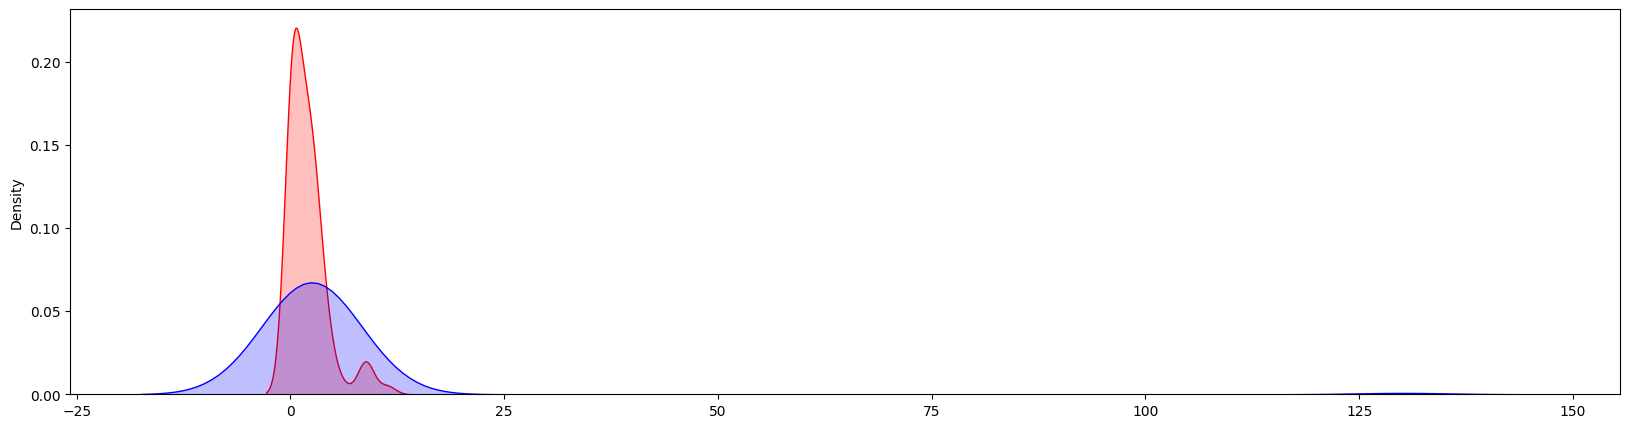

K Neighbors Regressor         


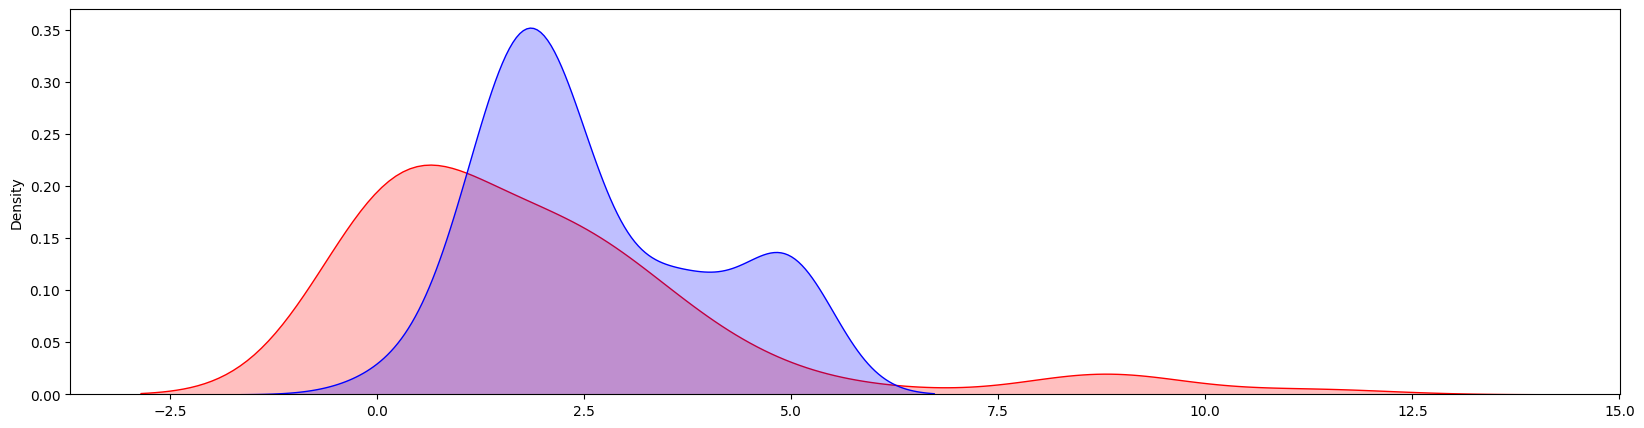

Lasso Regression              


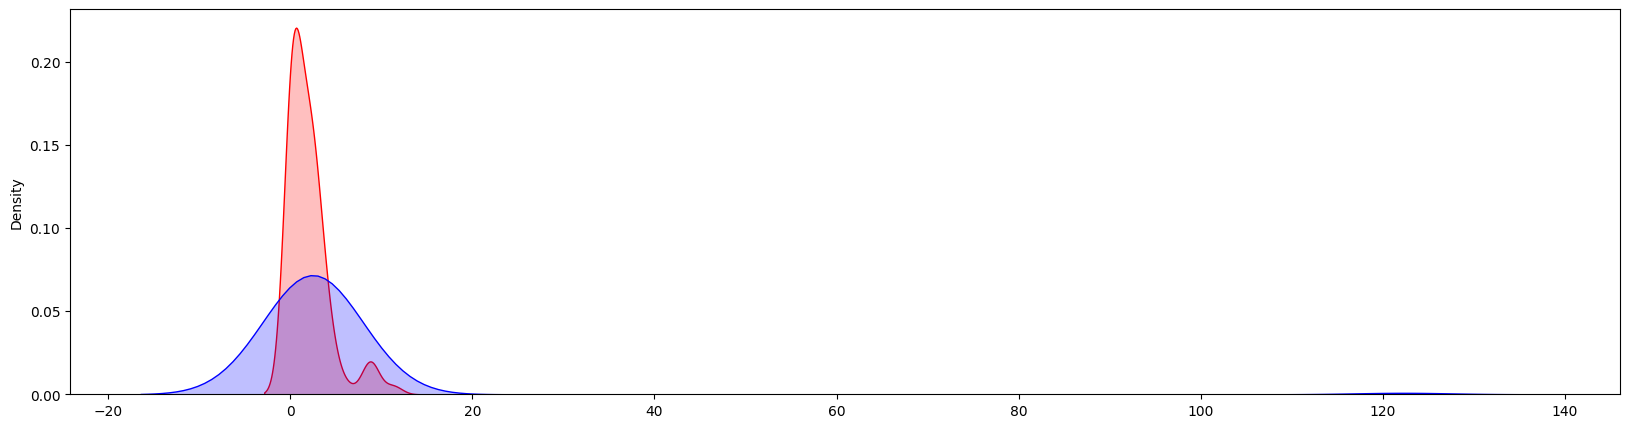

Support Vector Regressor      


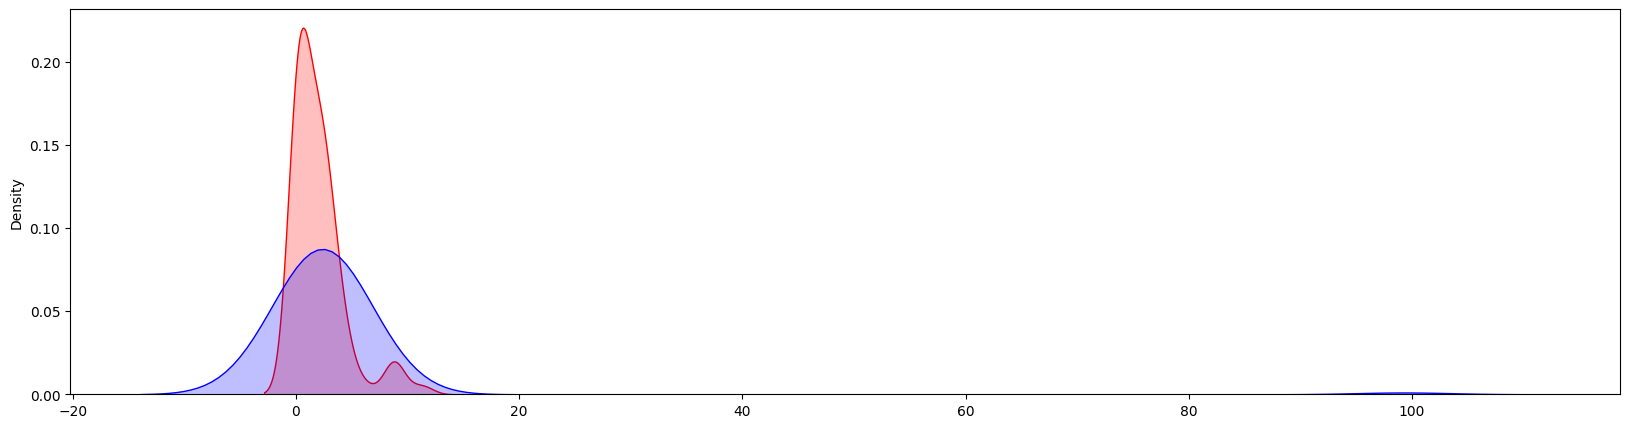

ANN                           


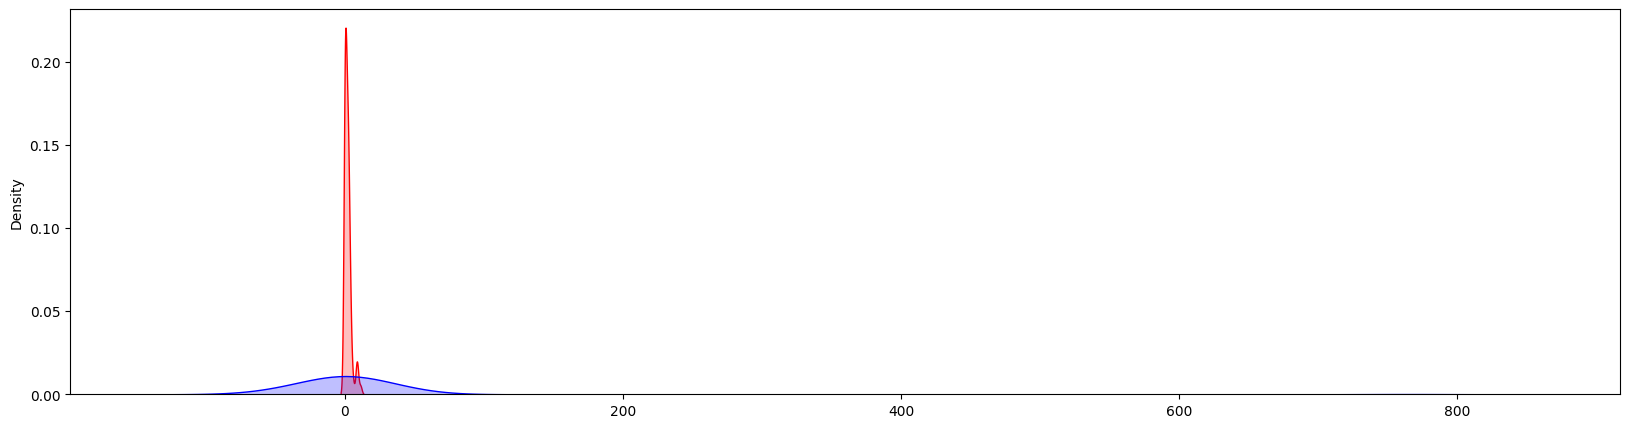

Random Forest Regressor       


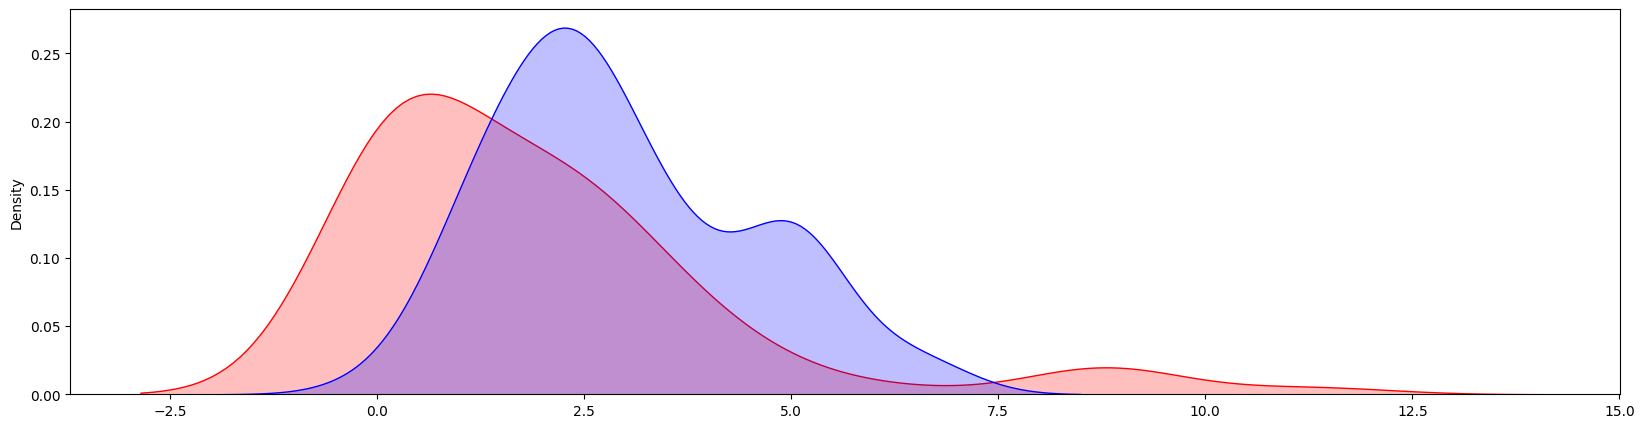

Gradient Boosting Regressor   


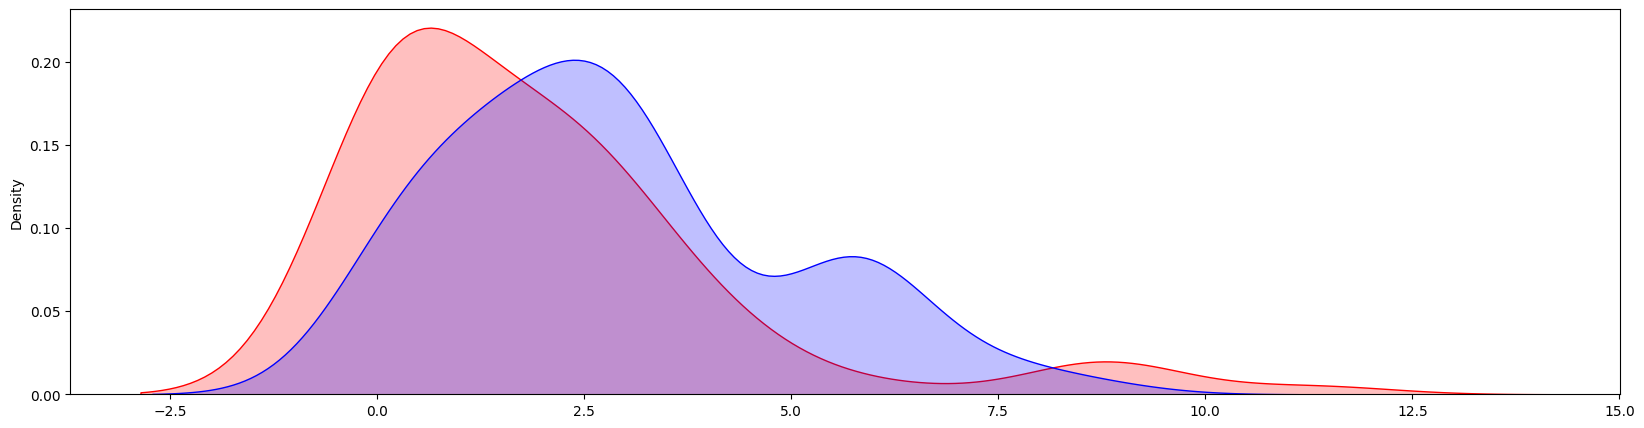

In [195]:
# Get Output variables
PCE = df_02_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_02_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
for m in models:
    scores = -1 * cross_val_score(m[1], X, y_PCE, cv=3, scoring='neg_mean_absolute_error')
    print(f'{m[0]:30}: {scores.mean()}')
print()

for m in models:
    y_pred = cross_val_predict(m[1], X, y_PCE, cv=3)
    print(f'{m[0]:30}')
    fig = sns.kdeplot(y_PCE, fill=True, color="r")
    fig = sns.kdeplot(y_pred, fill=True, color="b")
    plt.show()

hopt
Linear Regression             : 8.038663388623483
K Neighbors Regressor         : 6.364142857142856
Lasso Regression              : 8.007273656504204
Support Vector Regressor      : 5.34461555440848
ANN                           : 8.52721427353884
Random Forest Regressor       : 6.630055754435108
Gradient Boosting Regressor   : 7.534610430890592

Linear Regression             


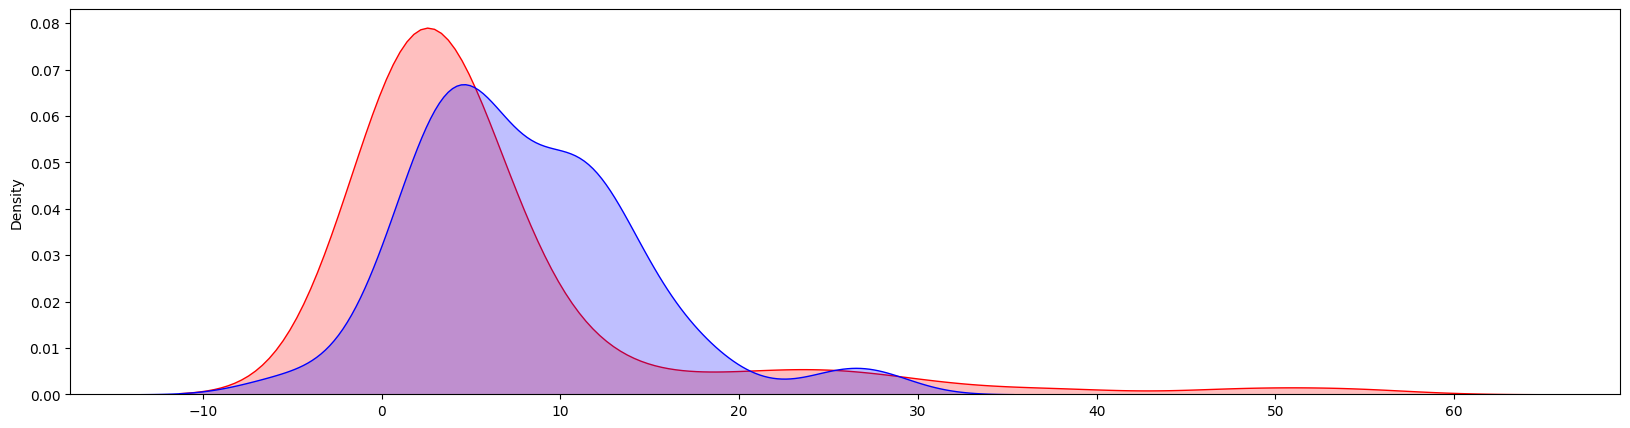

K Neighbors Regressor         


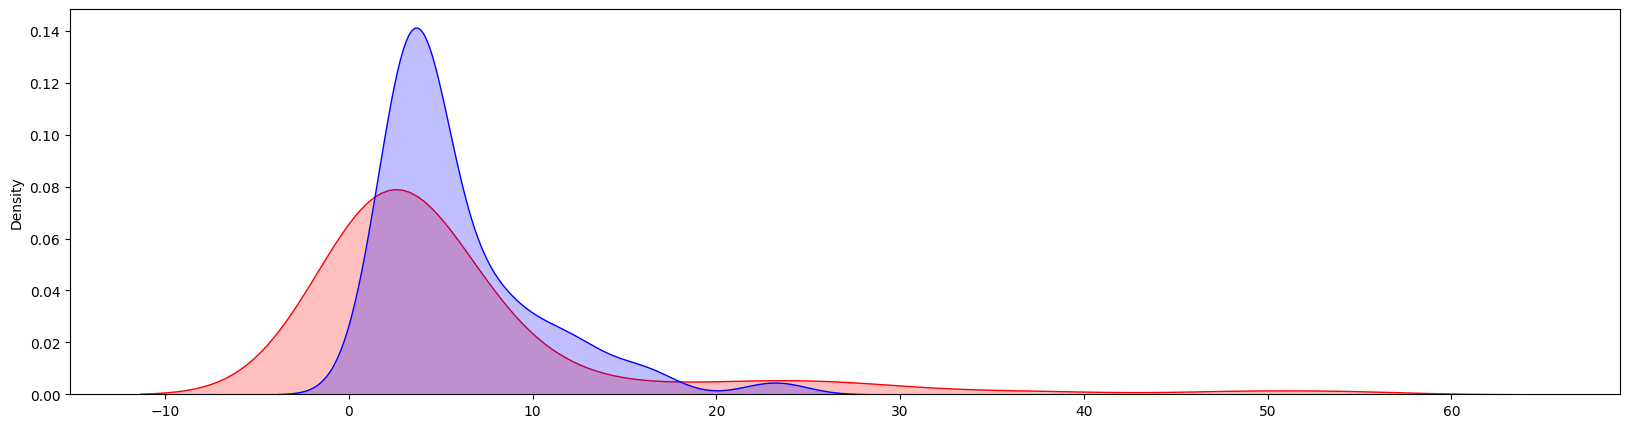

Lasso Regression              


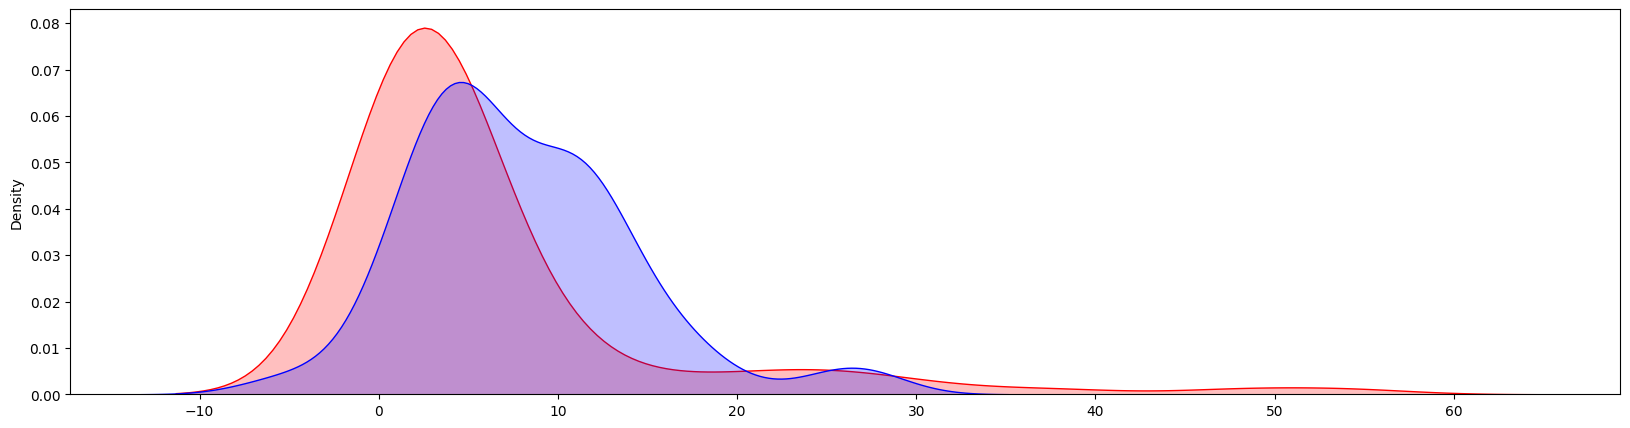

Support Vector Regressor      


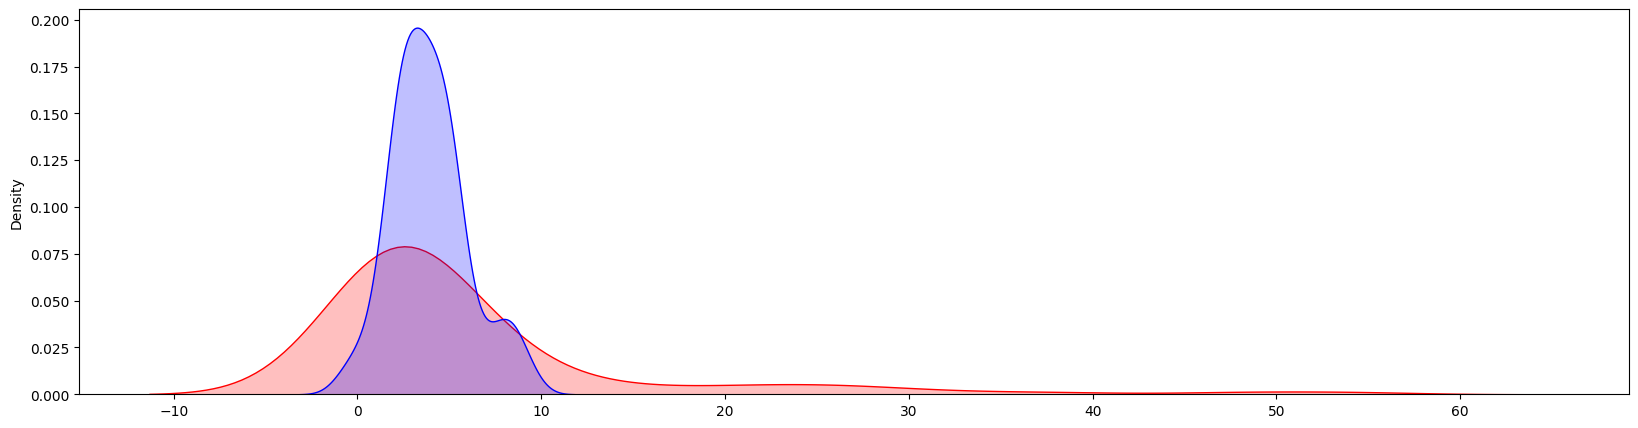

ANN                           


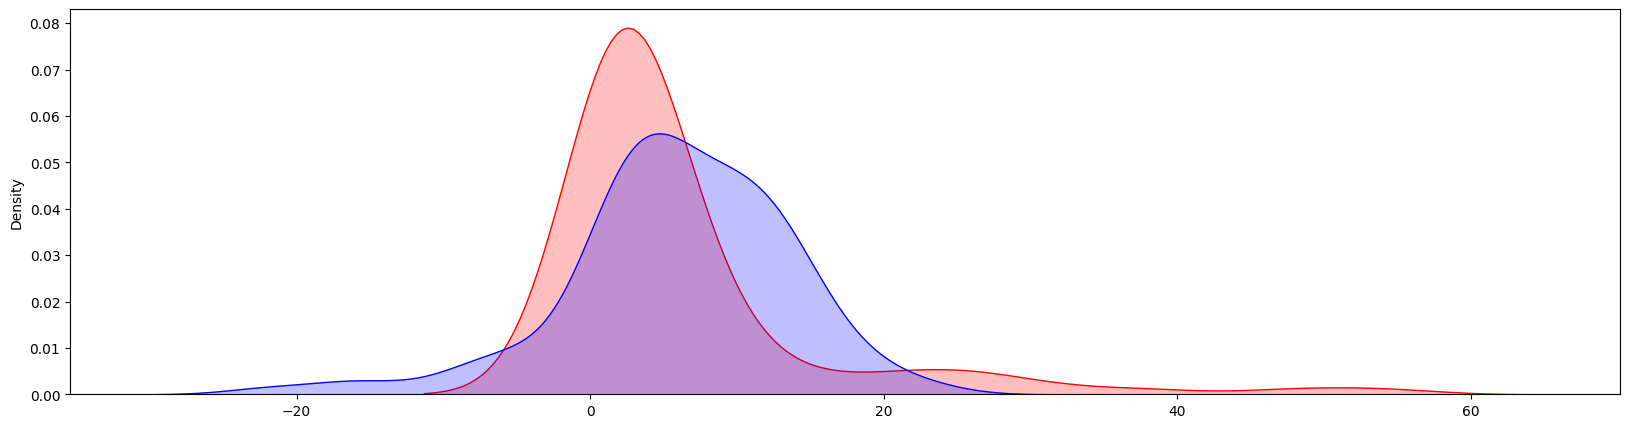

Random Forest Regressor       


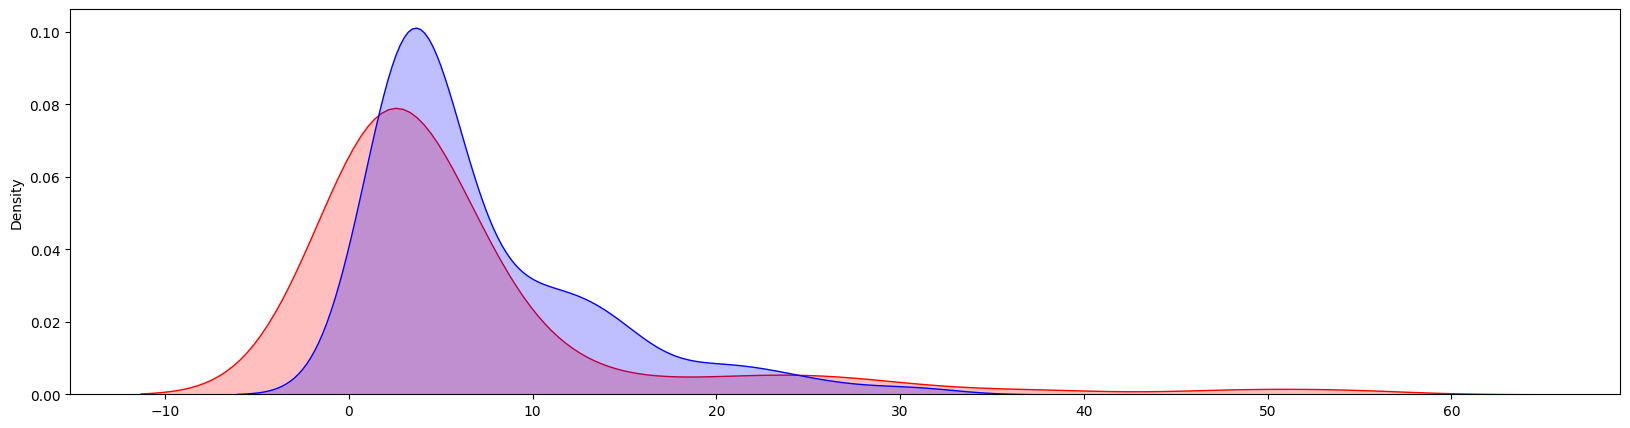

Gradient Boosting Regressor   


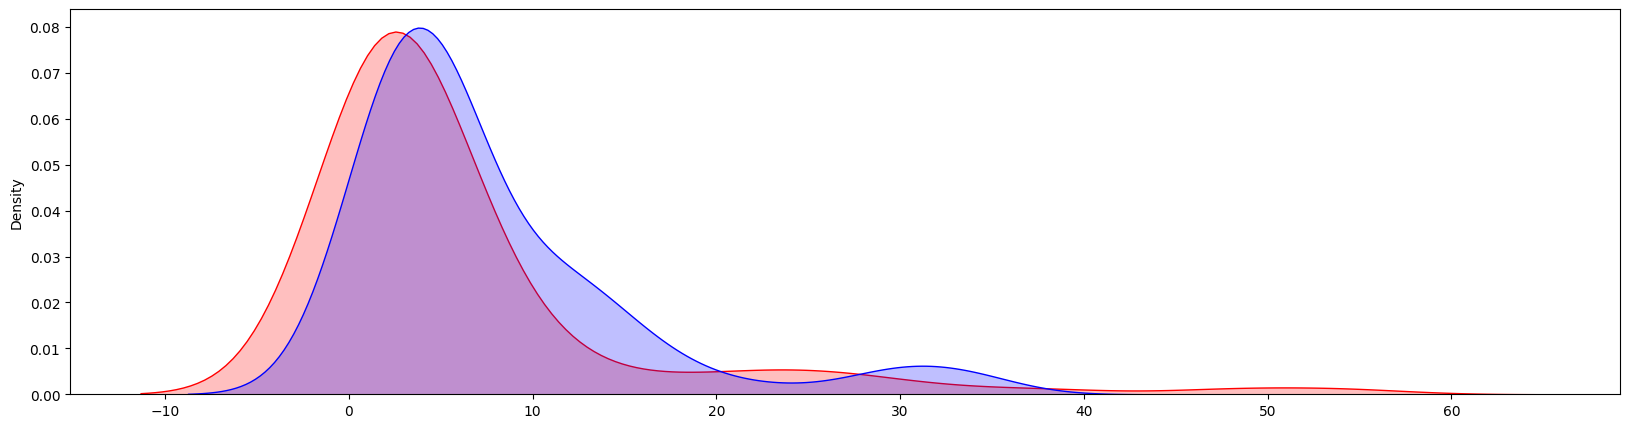

In [196]:
# Get Output variables
hopt = df_02_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_02_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()


## hopt
print(f'hopt')
for m in models:
    scores = -1 * cross_val_score(m[1], X, y_hopt, cv=3, scoring='neg_mean_absolute_error')
    print(f'{m[0]:30}: {scores.mean()}')
print()

for m in models:
    y_pred = cross_val_predict(m[1], X, y_hopt, cv=3)
    print(f'{m[0]:30}')
    fig = sns.kdeplot(y_hopt, fill=True, color="r")
    fig = sns.kdeplot(y_pred, fill=True, color="b")
    plt.show()

### Adding the categorical features (Mat0 and Mat1)

In [197]:
df_03_PCE = df.drop(['hopt (%)'])
df_03_PCE = df_03_PCE.drop_nulls()

total, _ = df_03_PCE.shape
for col in df_03_PCE.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_03_PCE

mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


shape: (85, 10)
┌──────┬──────────┬──────────┬─────────┬─────┬────────┬────────┬────────┬─────────┐
│ mat0 ┆ mat1     ┆ abs_peak ┆ abs_min ┆ ... ┆ em_min ┆ em_max ┆ QY (%) ┆ PCE (%) │
│ ---  ┆ ---      ┆ ---      ┆ ---     ┆     ┆ ---    ┆ ---    ┆ ---    ┆ ---     │
│ str  ┆ str      ┆ i64      ┆ i64     ┆     ┆ i64    ┆ i64    ┆ f64    ┆ f64     │
╞══════╪══════════╪══════════╪═════════╪═════╪════════╪════════╪════════╪═════════╡
│ QD   ┆ solution ┆ 800      ┆ 400     ┆ ... ┆ 700    ┆ 1000   ┆ 30.0   ┆ 3.2     │
│ QD   ┆ solution ┆ 600      ┆ 400     ┆ ... ┆ 600    ┆ 700    ┆ 50.0   ┆ 1.2     │
│ dye  ┆ bulk     ┆ 580      ┆ 300     ┆ ... ┆ 600    ┆ 800    ┆ 100.0  ┆ 0.0018  │
│ dye  ┆ film     ┆ 745      ┆ 400     ┆ ... ┆ 700    ┆ 900    ┆ 25.0   ┆ 0.61    │
│ ...  ┆ ...      ┆ ...      ┆ ...     ┆ ... ┆ ...    ┆ ...    ┆ ...    ┆ ...     │
│ QD   ┆ bulk     ┆ 600      ┆ 400     ┆ ... ┆ 550    ┆ 700    ┆ 30.0   ┆ 0.38    │
│ QD   ┆ bulk     ┆ 350      ┆ 300     ┆ ... ┆ 425    ┆ 700    ┆ 91.0   ┆ 4.29    │
│ QD   ┆ bulk     ┆ 350      ┆ 300     ┆ ... ┆ 425    ┆ 700    ┆ 91.0   ┆ 0.55    │
│ QD   ┆ bulk     ┆ 350      ┆ 300     ┆ ... ┆ 450    ┆ 700    ┆ 11.0   ┆ 0.77    │
└──────┴──────────┴──────────┴─────────┴─────┴────────┴────────┴────────┴─────────┘

In [198]:
df_03_hopt = df.drop(['PCE (%)'])
df_03_hopt = df_03_hopt.drop_nulls()

total, _ = df_03_hopt.shape
for col in df_03_hopt.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_03_hopt

mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


shape: (103, 10)
┌──────┬──────────┬──────────┬─────────┬─────┬────────┬────────┬────────┬──────────┐
│ mat0 ┆ mat1     ┆ abs_peak ┆ abs_min ┆ ... ┆ em_min ┆ em_max ┆ QY (%) ┆ hopt (%) │
│ ---  ┆ ---      ┆ ---      ┆ ---     ┆     ┆ ---    ┆ ---    ┆ ---    ┆ ---      │
│ str  ┆ str      ┆ i64      ┆ i64     ┆     ┆ i64    ┆ i64    ┆ f64    ┆ f64      │
╞══════╪══════════╪══════════╪═════════╪═════╪════════╪════════╪════════╪══════════╡
│ dye  ┆ film     ┆ 578      ┆ 420     ┆ ... ┆ 550    ┆ 750    ┆ 98.0   ┆ 18.8     │
│ QD   ┆ solution ┆ 800      ┆ 400     ┆ ... ┆ 700    ┆ 1000   ┆ 30.0   ┆ 1.4      │
│ QD   ┆ solution ┆ 600      ┆ 400     ┆ ... ┆ 600    ┆ 700    ┆ 50.0   ┆ 0.5      │
│ QD   ┆ solution ┆ 376      ┆ 300     ┆ ... ┆ 600    ┆ 700    ┆ 50.0   ┆ 0.3      │
│ ...  ┆ ...      ┆ ...      ┆ ...     ┆ ... ┆ ...    ┆ ...    ┆ ...    ┆ ...      │
│ CD   ┆ film     ┆ 355      ┆ 300     ┆ ... ┆ 450    ┆ 650    ┆ 15.01  ┆ 2.76     │
│ CD   ┆ film     ┆ 410      ┆ 300     ┆ ... ┆ 550    ┆ 750    ┆ 7.6    ┆ 2.77     │
│ CD   ┆ film     ┆ 400      ┆ 300     ┆ ... ┆ 450    ┆ 750    ┆ 22.0   ┆ 4.03     │
│ QD   ┆ bulk     ┆ 600      ┆ 400     ┆ ... ┆ 550    ┆ 700    ┆ 30.0   ┆ 2.7      │
└──────┴──────────┴──────────┴─────────┴─────┴────────┴────────┴────────┴──────────┘

PCE
Linear Regression             : 3.492789188796287
K Neighbors Regressor         : 2.124548673234811
Lasso Regression              : 3.6610388612577336
Support Vector Regressor      : 2.02051687318343
ANN                           : 23.507150916952877
Random Forest Regressor       : 2.44936483394294
Gradient Boosting Regressor   : 2.6829500260435686

Linear Regression             


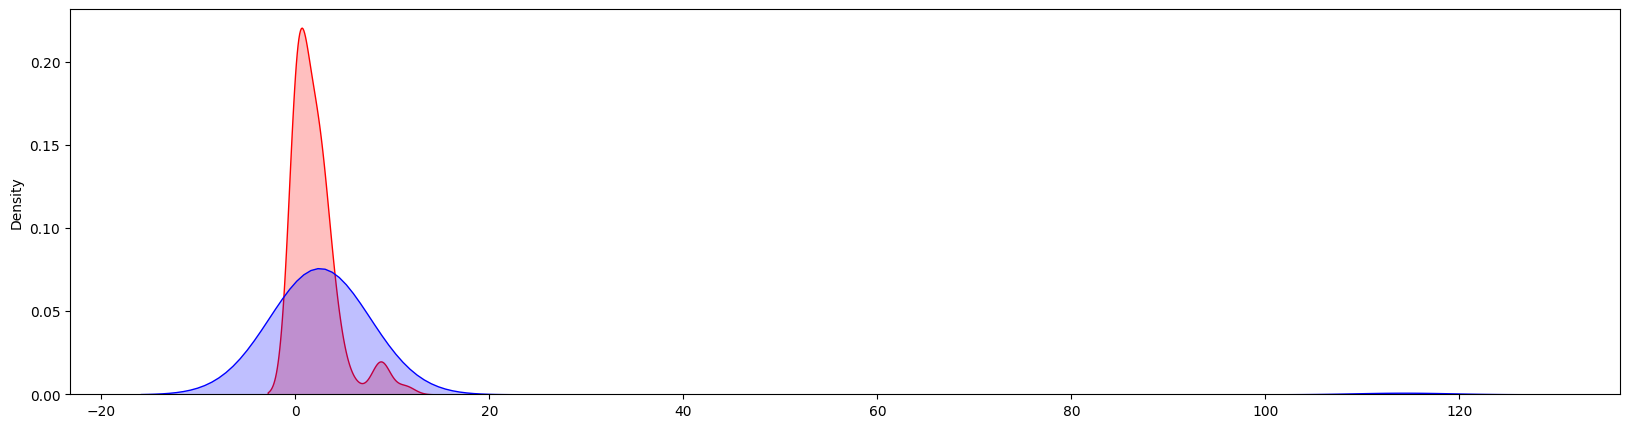

K Neighbors Regressor         


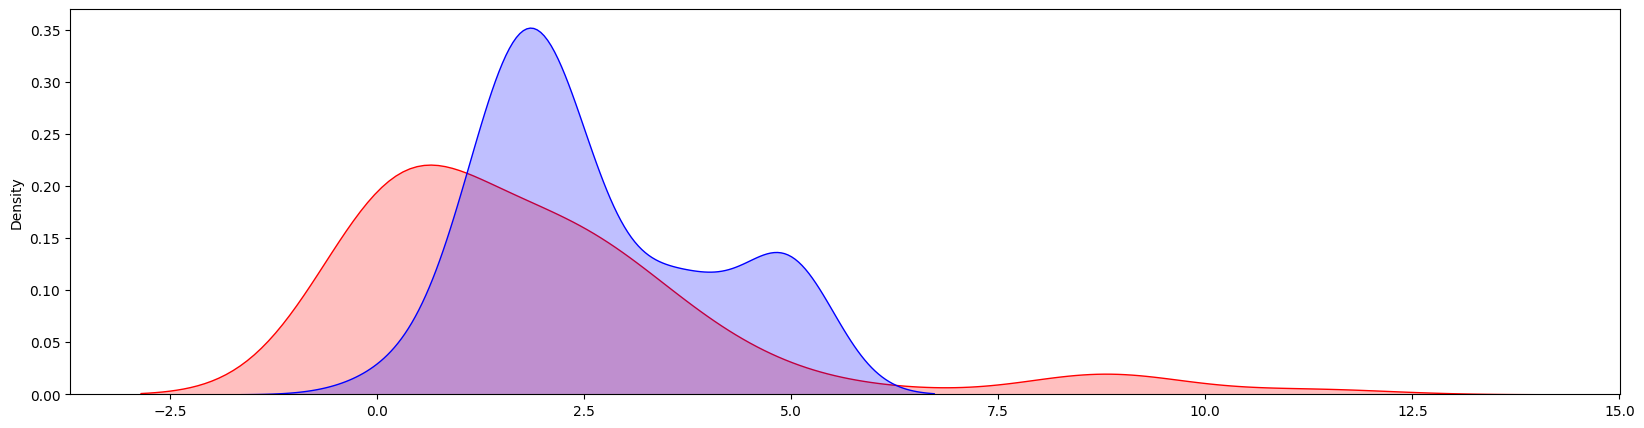

Lasso Regression              


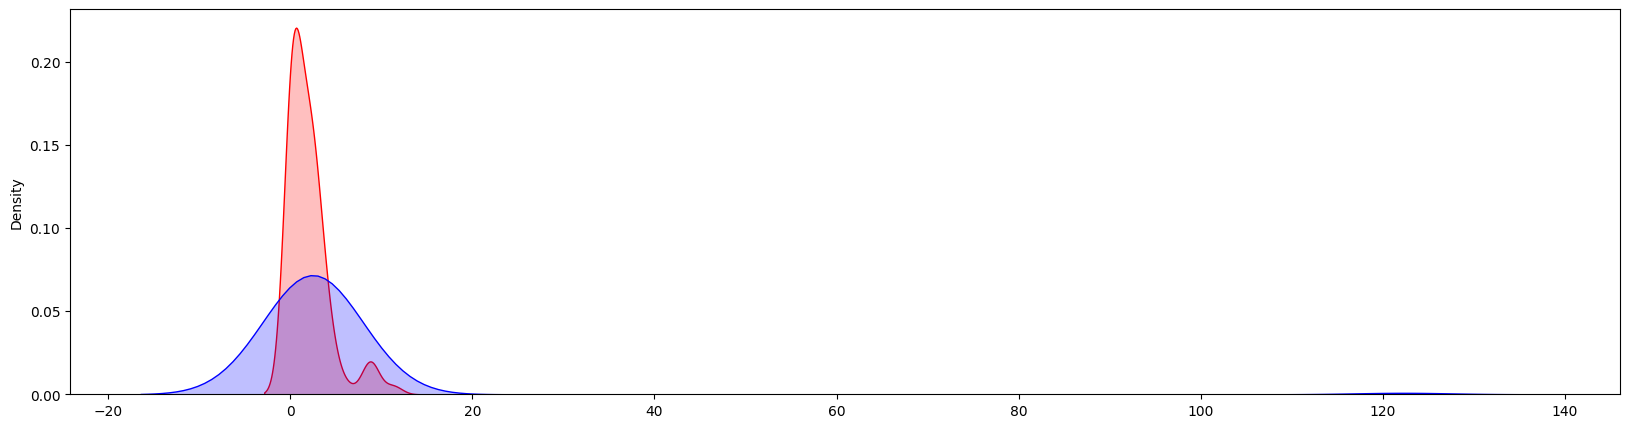

Support Vector Regressor      


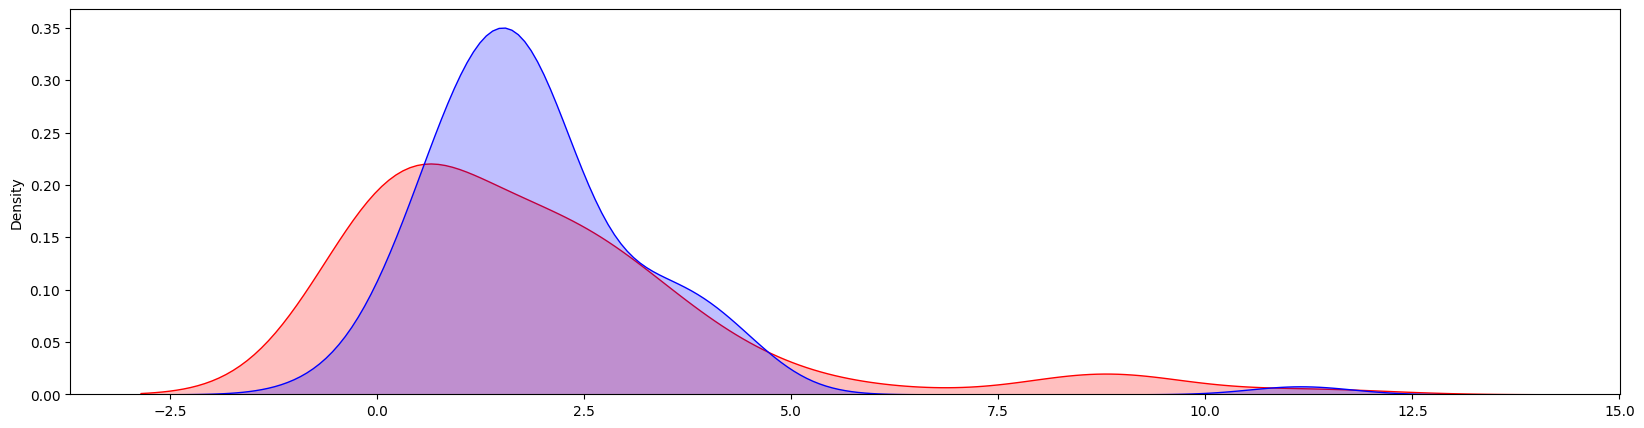

ANN                           


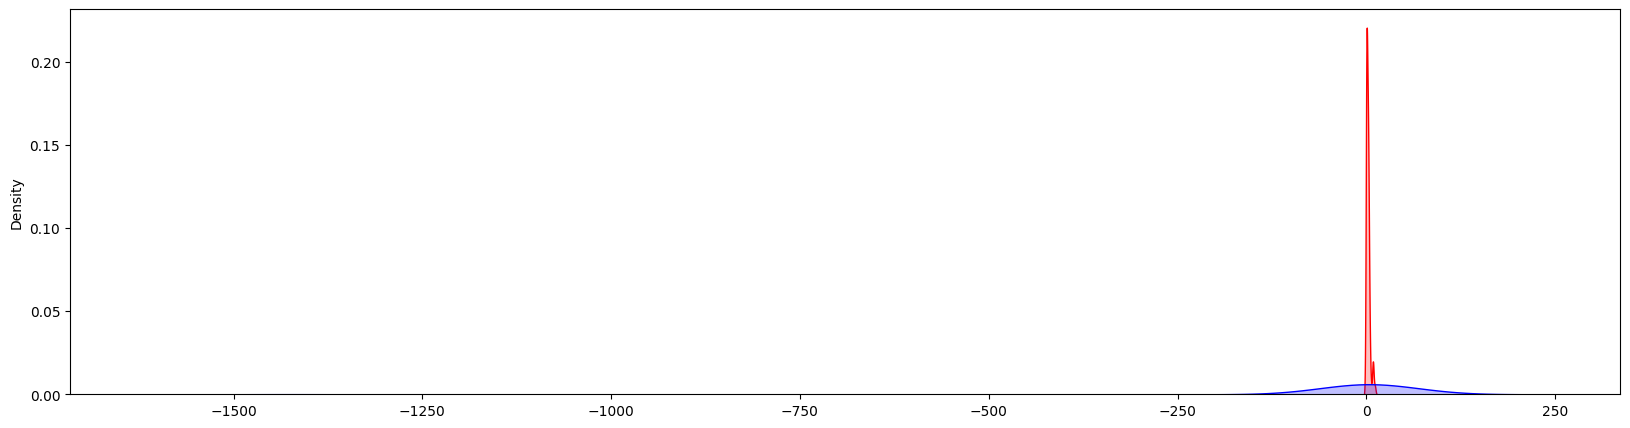

Random Forest Regressor       


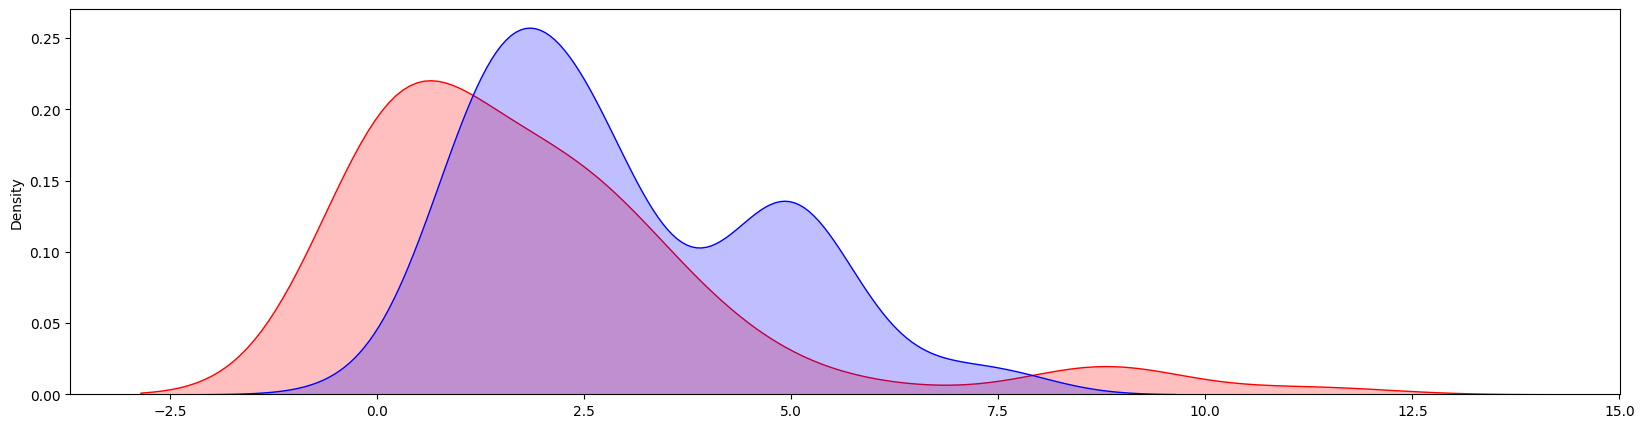

Gradient Boosting Regressor   


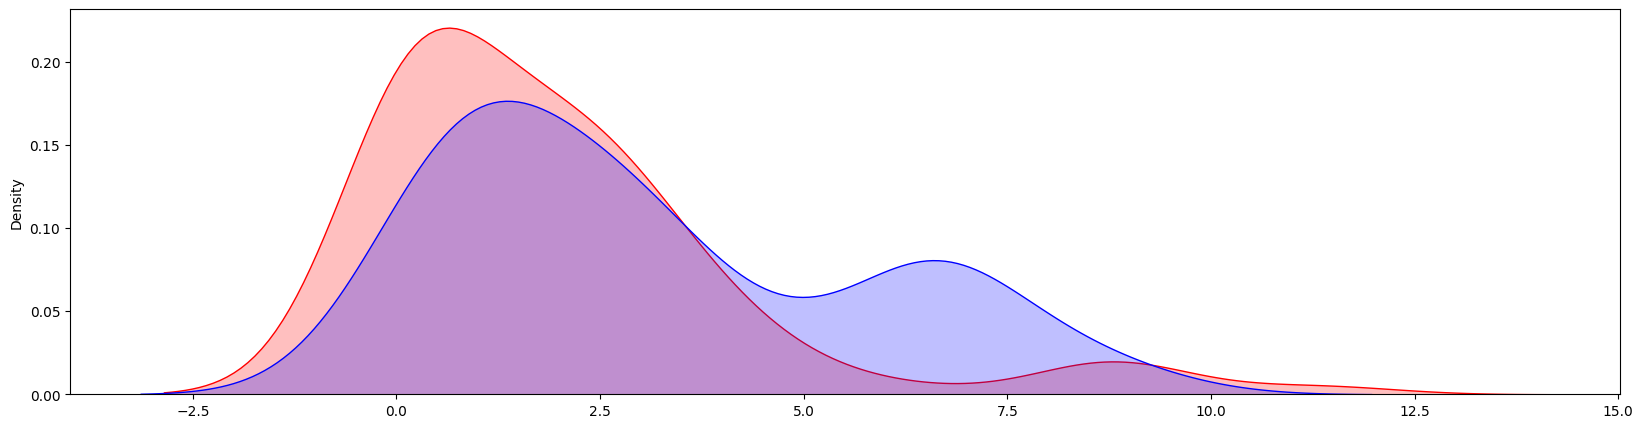

In [199]:
# Get Output variables
PCE = df_03_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_03_PCE.drop(['mat0', 'mat1', 'PCE (%)'])
X = df_input.to_numpy()

temp_array = df_03_PCE[['mat0', 'mat1']].to_numpy()
enc = OneHotEncoder(sparse_output=False)
encoded = enc.fit_transform(temp_array)
X = np.concatenate((encoded, X), axis=1)

## PCE
print(f'PCE')
for m in models:
    scores = -1 * cross_val_score(m[1], X, y_PCE, cv=3, scoring='neg_mean_absolute_error')
    print(f'{m[0]:30}: {scores.mean()}')
print()

for m in models:
    y_pred = cross_val_predict(m[1], X, y_PCE, cv=3)
    print(f'{m[0]:30}')
    fig = sns.kdeplot(y_PCE, fill=True, color="r")
    fig = sns.kdeplot(y_pred, fill=True, color="b")
    plt.show()

hopt
Linear Regression             : 7.991020529541099
K Neighbors Regressor         : 6.355990476190475
Lasso Regression              : 7.612724815605777
Support Vector Regressor      : 5.3830842095223685
ANN                           : 29.777333296852493
Random Forest Regressor       : 6.11630885079365
Gradient Boosting Regressor   : 5.759668779125737

Linear Regression             


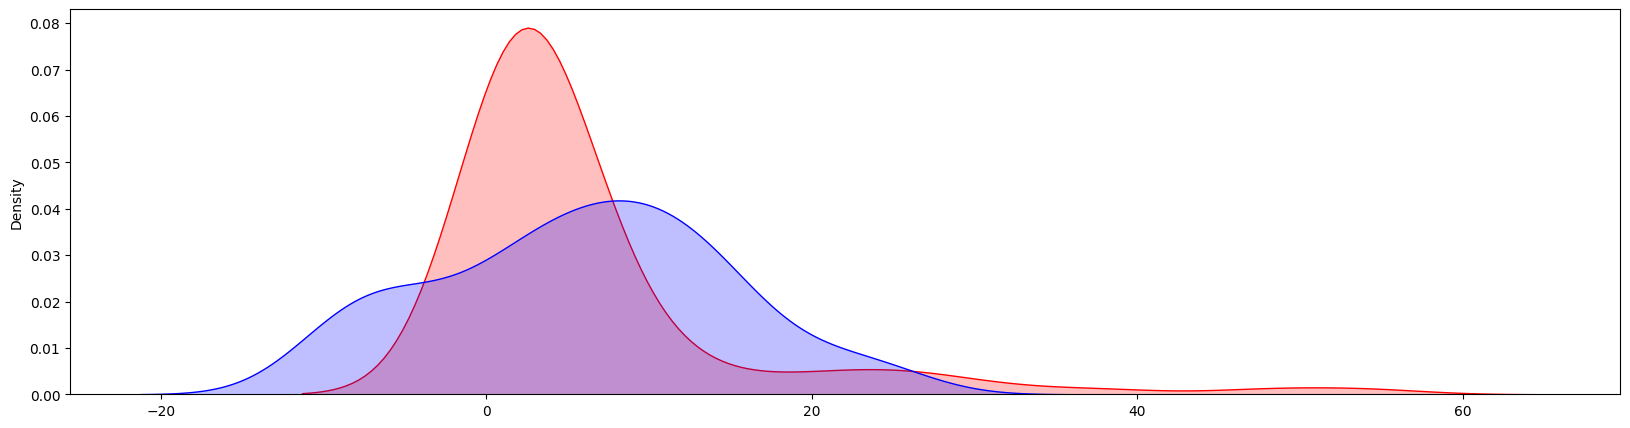

K Neighbors Regressor         


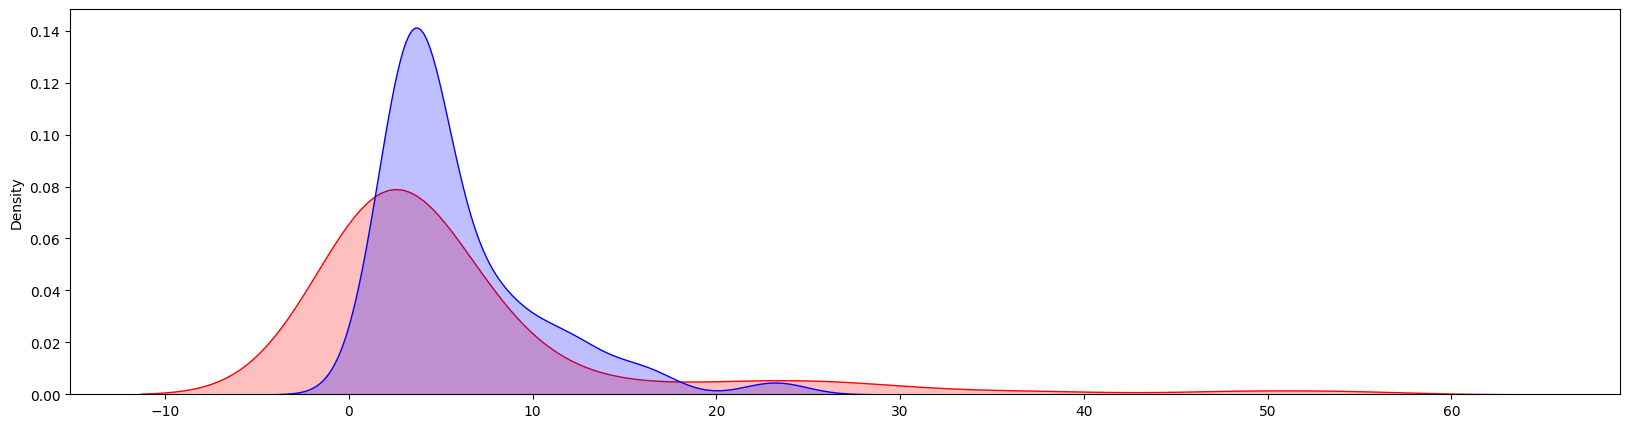

Lasso Regression              


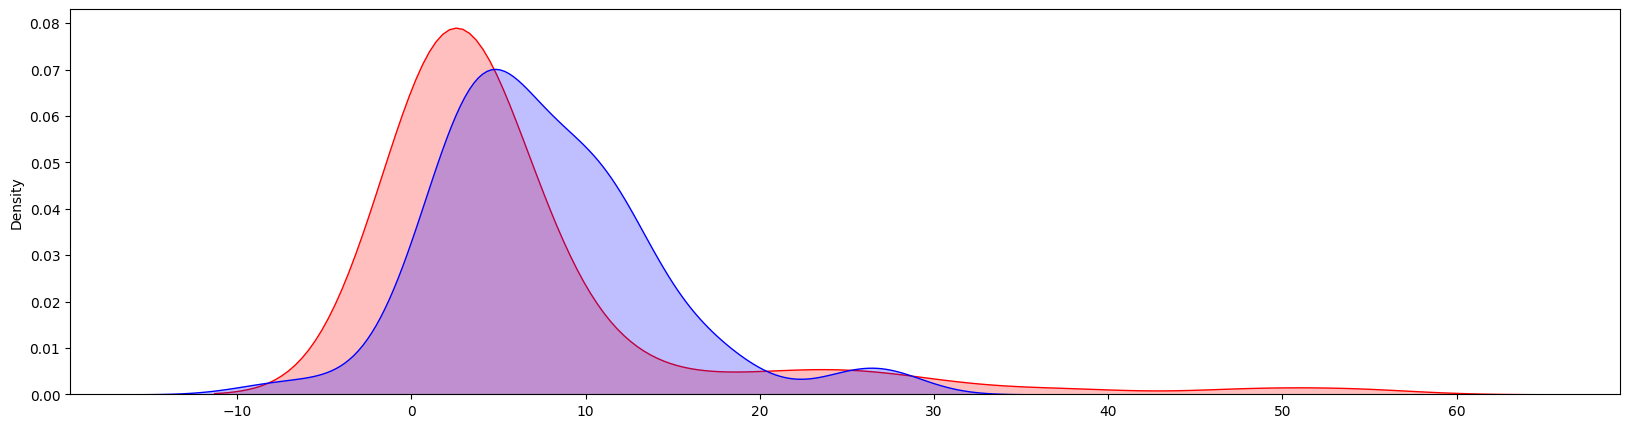

Support Vector Regressor      


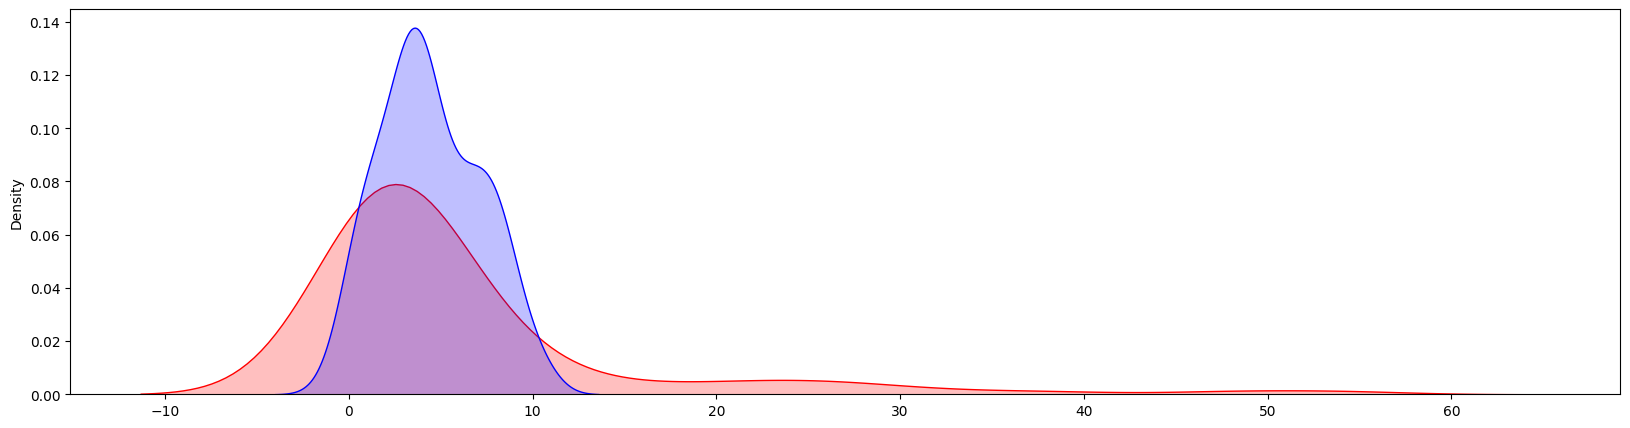

ANN                           


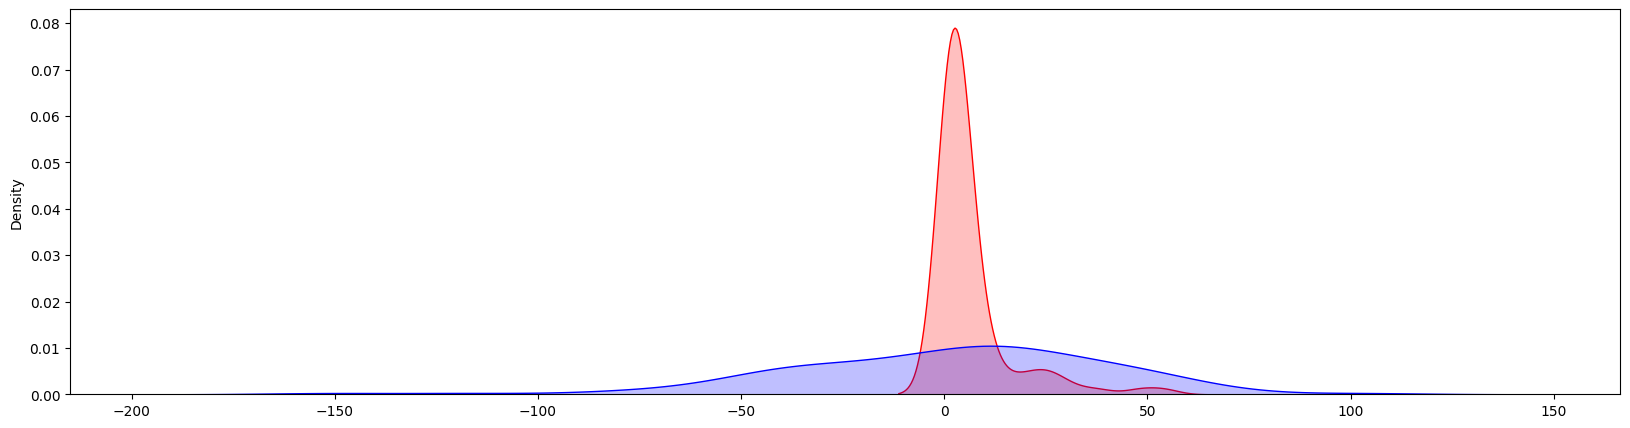

Random Forest Regressor       


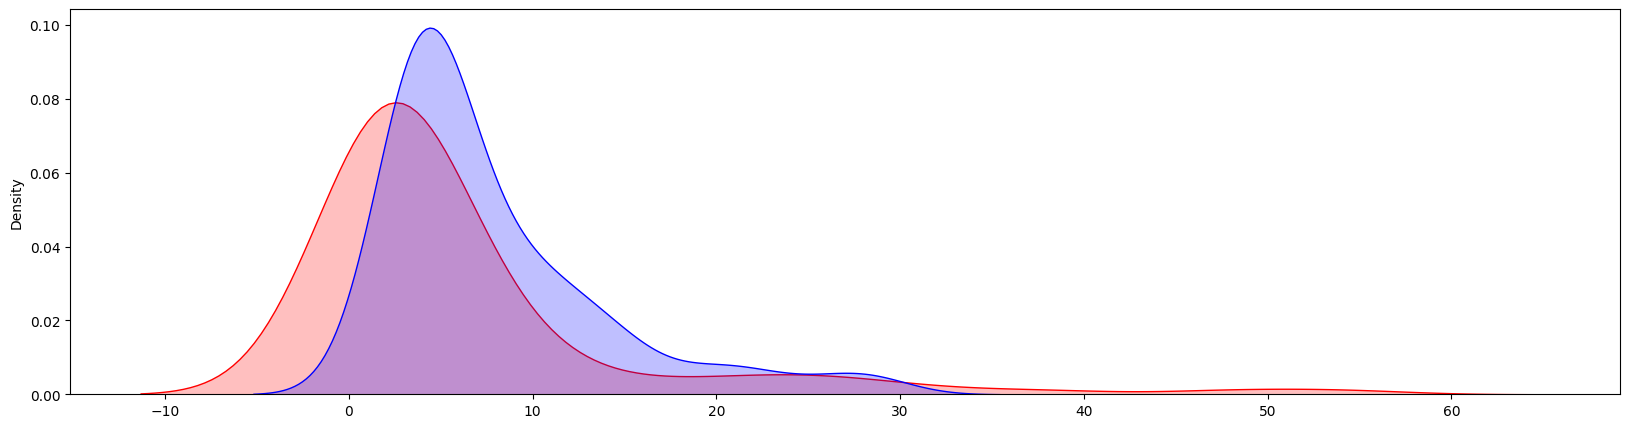

Gradient Boosting Regressor   


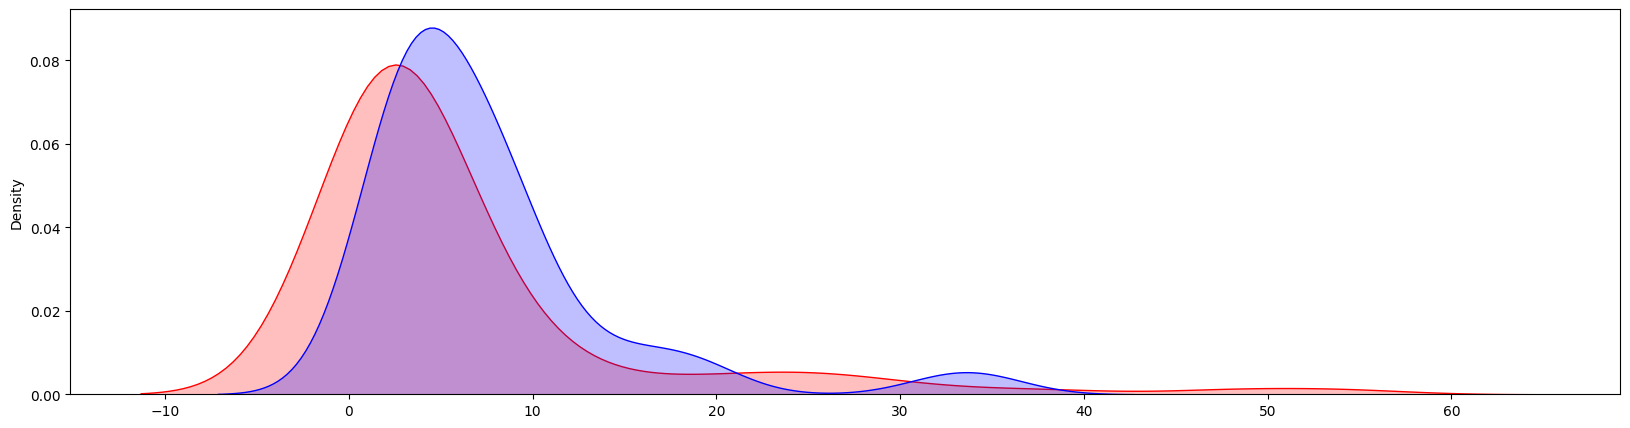

In [200]:
# Get Output variables
hopt = df_03_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_03_hopt.drop(['mat0', 'mat1', 'hopt (%)'])
X = df_input.to_numpy()

temp_array = df_03_hopt[['mat0', 'mat1']].to_numpy()
enc = OneHotEncoder(sparse_output=False)
encoded = enc.fit_transform(temp_array)
X = np.concatenate((encoded, X), axis=1)

## hopt
print(f'hopt')
for m in models:
    scores = -1 * cross_val_score(m[1], X, y_hopt, cv=3, scoring='neg_mean_absolute_error')
    print(f'{m[0]:30}: {scores.mean()}')
print()

for m in models:
    y_pred = cross_val_predict(m[1], X, y_hopt, cv=3)
    print(f'{m[0]:30}')
    fig = sns.kdeplot(y_hopt, fill=True, color="r")
    fig = sns.kdeplot(y_pred, fill=True, color="b")
    plt.show()

## Previous version

In [201]:
X = df[['abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']].to_numpy()
X[np.isnan(X)] = 0
X

array([[5.78e+02, 4.20e+02, 6.00e+02, ..., 9.80e+01, 1.88e+01, 0.00e+00],
       [5.40e+02, 4.00e+02, 6.00e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [5.40e+02, 4.00e+02, 6.00e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [3.50e+02, 3.00e+02, 5.00e+02, ..., 9.10e+01, 0.00e+00, 4.29e+00],
       [3.50e+02, 3.00e+02, 5.00e+02, ..., 9.10e+01, 0.00e+00, 5.50e-01],
       [3.50e+02, 3.00e+02, 5.00e+02, ..., 1.10e+01, 0.00e+00, 7.70e-01]])

In [202]:
# Get the Original Values
QY = X.T[6]
hopt = X.T[7]
PCE = X.T[8]

# Get the Masks for the non-zero values
QY_MASK = QY != 0
hopt_MASK = hopt != 0
PCE_MASK = PCE != 0

# Convert boolean mask to index one
QY_MASK = [i for i in range(len(QY_MASK)) if QY_MASK[i]]
hopt_MASK = [i for i in range(len(hopt_MASK)) if hopt_MASK[i]]
PCE_MASK = [i for i in range(len(PCE_MASK)) if PCE_MASK[i]]

# Compute the average and standard deviation
QY_AVG = np.average(QY[QY_MASK])
QY_STD = np.std(QY[QY_MASK])

hopt_AVG = np.average(hopt[hopt_MASK])
hopt_STD = np.std(hopt[hopt_MASK])

PCE_AVG = np.average(PCE[PCE_MASK])
PCE_STD = np.std(PCE[PCE_MASK])

test = .3
random.seed(42)

# Select the index of the test set
QY_TEST_SET_INDEX = random.sample(QY_MASK, int(len(QY_MASK)*test))
hopt_TEST_SET_INDEX = random.sample(hopt_MASK, int(len(hopt_MASK)*test))
PCE_TEST_SET_INDEX = random.sample(PCE_MASK, int(len(PCE_MASK)*test))

print(f'{QY_TEST_SET_INDEX}\n{hopt_TEST_SET_INDEX}\n{PCE_TEST_SET_INDEX}')

[42, 13, 95, 86, 79, 52, 38, 168, 33, 135, 15, 14, 35, 77, 83, 156, 174, 71, 134, 78, 171, 100, 170, 130, 138, 0, 123, 150, 29, 114, 75, 63, 151, 28, 41, 147, 142, 22, 18, 69, 19, 66, 65, 102]
[48, 155, 7, 144, 93, 106, 19, 79, 13, 108, 54, 161, 130, 129, 69, 121, 37, 141, 11, 170, 135, 42, 162, 164, 147, 15, 165, 51, 168, 131, 171, 31, 77, 68, 39]
[158, 75, 162, 160, 149, 28, 143, 148, 53, 130, 72, 51, 113, 96, 174, 168, 136, 61, 83, 26, 70, 21, 82, 100, 172, 27, 60, 138, 146, 141]


In [203]:
# Store original values from the test set
QY_TEST_SET = QY[QY_TEST_SET_INDEX]
hopt_TEST_SET = hopt[hopt_TEST_SET_INDEX]
PCE_TEST_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_TEST_SET}\n{hopt_TEST_SET}\n{PCE_TEST_SET}')

# Replace the test set with zeros
QY[QY_TEST_SET_INDEX] = 0
hopt[hopt_TEST_SET_INDEX] = 0
PCE[PCE_TEST_SET_INDEX] = 0

print(f'{QY[QY_TEST_SET_INDEX]}\n{hopt[hopt_TEST_SET_INDEX]}\n{PCE[PCE_TEST_SET_INDEX]}')

[ 94.    11.    30.    27.    95.    25.    36.2   41.52  80.    70.
  45.     9.    40.    17.    65.    35.    91.    24.    40.    70.
  22.    44.     7.6   51.    82.    98.    20.    11.54  97.6   95.
  23.    53.    35.91  25.    45.    81.    15.7   14.   100.    44.3
  67.    61.1   89.5   73.  ]
[ 1.85  3.76  1.4   2.9   1.2   3.7   5.5  23.7   0.6   2.1   1.45  3.13
  3.3   2.58 24.7   1.    3.67 19.    3.4   2.77  2.3   3.9   2.6   4.3
  3.4   1.    1.23  4.75  3.51  2.7   4.03  0.29  1.5  27.8  12.23]
[2.30e+00 2.80e-01 2.30e+00 1.60e-01 4.36e+00 1.41e+00 1.90e+00 2.06e+00
 2.85e+00 3.50e-01 6.20e-01 3.94e+00 2.10e+00 9.00e-04 5.50e-01 2.39e+00
 1.13e+00 3.94e+00 1.13e+01 1.24e+00 4.40e-01 5.50e-01 1.90e-01 4.41e-02
 3.80e-01 5.40e-01 3.27e+00 1.80e-01 4.10e+00 2.90e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [204]:
# Write on the X Matrix again
X.T[6] = QY
X.T[7] = hopt
X.T[8] = PCE

In [205]:
# Grid Search
ks = [2,3,4,5,6,7,8]
seeds = [53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# Store best solution (min cost)
min_cost = float('inf')
solution = None

for k in ks:
    for s in seeds:
        Xr, W, H, cost = nmf.nmf_mu(X, k=k, seed=s)
        if cost < min_cost:
            min_cost = cost
            solution = (k, s)

In [206]:
print(f"{cost} {solution}")

219.33644638376518 (8, 67)


In [207]:
# Measure the performance of the reconstruction
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Get the predicted QY, hopt and PCE
QY = Xr.T[6]
hopt = Xr.T[7]
PCE = Xr.T[8]

QY_PREDICT_SET = QY[QY_TEST_SET_INDEX]
hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_PREDICT_SET}\n{hopt_PREDICT_SET}\n{PCE_PREDICT_SET}')

[69.69440014 98.61575405 41.85721242 68.04289092 36.03632989 59.003672
 50.80151976 70.96237886 77.63305564 41.39701651 74.44240566 42.39566468
 82.42109037 36.94446361 25.6122494  76.1821254  66.47464362 82.43362272
 39.8548744  51.81728486 68.41483319 41.0961878  55.64711649 22.37376798
 32.38801399 26.60434277 61.34674426 41.33531977 18.42319408 39.86151717
 71.2218624  52.42087555 43.00829363 25.51504629 45.02127648 49.39782095
 33.85217911 51.24339019 55.30016372 54.13174425 70.76871764 33.33341017
 48.6828815  50.9276018 ]
[ 3.67252254  7.16877598  3.57920321  7.35965405  7.77468561  2.53941672
  5.34716326  4.32002182 10.06787409  7.53246709  4.02740227 10.37872368
  2.89276595  6.7710664   5.56338944  5.0470195  10.31027628  8.16962516
  7.60353903  6.58023459  2.84911609  8.08046816  7.58834443  7.20511
  9.79842735  8.43210198  6.14247134 13.07638162  6.25967704  3.26241327
  7.23201129  6.17374661  4.67945075  7.60558846 10.19401979]
[78.16892601  2.7030183   2.48795767  2.6

In [208]:
rmse_qy = math.sqrt(mean_squared_error(QY_TEST_SET, QY_PREDICT_SET))
rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))

print(f'RMSE(QY): {rmse_qy} ({QY_AVG} ± {QY_STD})')
print(f'RMSE(HOPT): {rmse_hopt} ({hopt_AVG} ± {hopt_STD})')
print(f'RMSE(PCE): {rmse_PCE} ({PCE_AVG} ± {PCE_STD})')

RMSE(QY): 37.92436178265611 (50.790136054421765 ± 27.97358044124094)
RMSE(HOPT): 7.4595104557253125 (5.943881355932203 ± 8.973595516536177)
RMSE(PCE): 14.04898947803544 (2.2683079411764706 ± 2.6576714681090032)


### Grid Search (optimize with test set)

In [209]:
# Grid Search
ks = [2,3,4,5,6,7,8]
seeds = [53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# Store best solution (min cost)
min_cost = float('inf')
solution = None

for k in ks:
    for s in seeds:
        Xr, _, _, _ = nmf.nmf_mu(X, k=k, seed=s)
        # Get the values with the mask
        hopt = Xr.T[7]
        PCE = Xr.T[8]
        hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
        PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]
        # Compute the cost of the test set
        rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
        rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))
        #cost = rmse_hopt + rmse_PCE
        #cost = rmse_hopt
        cost = rmse_PCE
        if cost < min_cost:
            min_cost = cost
            solution = (k, s)

In [210]:
print(f"{cost} {solution}")

23.196868623797183 (7, 67)


In [211]:
# Measure the performance of the reconstruction
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Get the predicted QY, hopt and PCE
QY = Xr.T[6]
hopt = Xr.T[7]
PCE = Xr.T[8]

QY_PREDICT_SET = QY[QY_TEST_SET_INDEX]
hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_PREDICT_SET}\n{hopt_PREDICT_SET}\n{PCE_PREDICT_SET}')

[ 19.11339393 115.87847623  63.43167941  82.92105566  54.05106279
  39.59133205  57.15388253  26.13795714  91.37646203  32.61356914
  92.32535557  75.48194011  20.74186756  49.25547058  32.91445171
  39.31359325  30.54040906  57.99526814  32.97636906  50.19503802
  35.06528539  57.3340313   76.67933312  43.50601261  64.35054686
  52.20916275  28.59592315  47.52096852  74.64167454  76.05652457
  43.70527421  55.72858423  23.99509983  79.39667706  34.01919255
  52.6501413   49.12348965  34.88360931  77.72076844  34.02296689
  27.39562955 119.94077717  66.30116216  45.6780657 ]
[ 3.5057154   3.19249441  4.46967981  8.01293933  9.28387038  3.49487296
  1.91237231  8.12982356 13.77079837 12.36391375  5.32503319  5.71298097
  6.82115951  9.47702988  3.62989358  7.02547575  7.7423184  12.30019409
  9.02629371  9.0375364   3.25213302  3.1667175  10.19968807  6.9369672
  6.41051921 12.13483911  7.79875608 10.45006456  3.03656326  3.8104068
  3.19147868  5.76857144  7.17579613  9.38401498  7.129

In [212]:
rmse_qy = math.sqrt(mean_squared_error(QY_TEST_SET, QY_PREDICT_SET))
rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))

print(f'RMSE(QY): {rmse_qy} ({QY_AVG} ± {QY_STD})')
print(f'RMSE(HOPT): {rmse_hopt} ({hopt_AVG} ± {hopt_STD})')
print(f'RMSE(PCE): {rmse_PCE} ({PCE_AVG} ± {PCE_STD})')

RMSE(QY): 37.564450680530136 (50.790136054421765 ± 27.97358044124094)
RMSE(HOPT): 7.628612405672037 (5.943881355932203 ± 8.973595516536177)
RMSE(PCE): 2.2682609908727613 (2.2683079411764706 ± 2.6576714681090032)


### Reconstruct the matrix

In [213]:
# Get the original matrix
X = df[['abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']].to_numpy()
X[np.isnan(X)] = 0
print(X.shape)

# Get the reconstructed matrix
Xr, _, _, _ = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Replace all zeros with reconstructed values
X[X==0] = Xr[X==0]

(176, 9)


In [214]:
X

array([[5.78000000e+02, 4.20000000e+02, 6.00000000e+02, ...,
        9.80000000e+01, 1.88000000e+01, 2.83599781e+00],
       [5.40000000e+02, 4.00000000e+02, 6.00000000e+02, ...,
        7.89745660e+01, 1.13138621e+01, 2.56243460e+00],
       [5.40000000e+02, 4.00000000e+02, 6.00000000e+02, ...,
        6.68744190e+01, 9.76894321e+00, 2.28159120e+00],
       ...,
       [3.50000000e+02, 3.00000000e+02, 5.00000000e+02, ...,
        9.10000000e+01, 1.19807029e+01, 4.29000000e+00],
       [3.50000000e+02, 3.00000000e+02, 5.00000000e+02, ...,
        9.10000000e+01, 1.19189796e+01, 5.50000000e-01],
       [3.50000000e+02, 3.00000000e+02, 5.00000000e+02, ...,
        1.10000000e+01, 1.29009550e+00, 7.70000000e-01]])

In [215]:
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])
_, cols = X.shape
field_names = df.columns
print(f'{field_names}')
df = pl.DataFrame({field_names[i+2]: X[:,i] for i in range(cols)})
df

['mat0', 'mat1', 'abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']


shape: (176, 9)
┌──────────┬─────────┬─────────┬─────────┬─────┬────────┬───────────┬───────────┬──────────┐
│ abs_peak ┆ abs_min ┆ abs_max ┆ em_peak ┆ ... ┆ em_max ┆ QY (%)    ┆ hopt (%)  ┆ PCE (%)  │
│ ---      ┆ ---     ┆ ---     ┆ ---     ┆     ┆ ---    ┆ ---       ┆ ---       ┆ ---      │
│ f64      ┆ f64     ┆ f64     ┆ f64     ┆     ┆ f64    ┆ f64       ┆ f64       ┆ f64      │
╞══════════╪═════════╪═════════╪═════════╪═════╪════════╪═══════════╪═══════════╪══════════╡
│ 578.0    ┆ 420.0   ┆ 600.0   ┆ 613.0   ┆ ... ┆ 750.0  ┆ 98.0      ┆ 18.8      ┆ 2.835998 │
│ 540.0    ┆ 400.0   ┆ 600.0   ┆ 590.0   ┆ ... ┆ 690.0  ┆ 78.974566 ┆ 11.313862 ┆ 2.562435 │
│ 540.0    ┆ 400.0   ┆ 600.0   ┆ 590.0   ┆ ... ┆ 690.0  ┆ 66.874419 ┆ 9.768943  ┆ 2.281591 │
│ 730.0    ┆ 600.0   ┆ 900.0   ┆ 910.0   ┆ ... ┆ 1000.0 ┆ 60.349273 ┆ 2.5       ┆ 2.80645  │
│ ...      ┆ ...     ┆ ...     ┆ ...     ┆ ... ┆ ...    ┆ ...       ┆ ...       ┆ ...      │
│ 600.0    ┆ 400.0   ┆ 650.0   ┆ 625.0   ┆ ... ┆ 700.0  ┆ 30.0      ┆ 2.7       ┆ 0.38     │
│ 350.0    ┆ 300.0   ┆ 500.0   ┆ 495.0   ┆ ... ┆ 700.0  ┆ 91.0      ┆ 11.980703 ┆ 4.29     │
│ 350.0    ┆ 300.0   ┆ 500.0   ┆ 495.0   ┆ ... ┆ 700.0  ┆ 91.0      ┆ 11.91898  ┆ 0.55     │
│ 350.0    ┆ 300.0   ┆ 500.0   ┆ 578.0   ┆ ... ┆ 700.0  ┆ 11.0      ┆ 1.290095  ┆ 0.77     │
└──────────┴─────────┴─────────┴─────────┴─────┴────────┴───────────┴───────────┴──────────┘

## Clustering

In [216]:
import sklearn.metrics as sklearn_metrics

def inertia_score(X, labels):
  """This is the same of scikit-learn's KMeans.inertia_, but it works also in case of only one label."""

  inertia = 0.0
  for label in set(labels):
    X_cluster = X[labels == label, :]
    centroid = np.mean(X_cluster, axis=0)
    inertia += np.sum((X_cluster - centroid) ** 2)
  return inertia


def calinski_harabasz_score(X, labels):
  """Wrapper function of Scikit-learn's calinski_harabasz_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.calinski_harabasz_score(X, labels)


def davies_bouldin_score(X, labels):
  """Wrapper function of Scikit-learn's davies_bouldin_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.davies_bouldin_score(X, labels)


def silhouette_score(X, labels):
  """Wrapper function of Scikit-learn's silhouette_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.silhouette_score(X, labels)


def get_bic_aic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return gmm.bic(X), gmm.aic(X)

In [217]:
# Cluster the materials without the hopt and PCE
print(f'{df}')
df_input = df.drop(['hopt (%)', 'PCE (%)'])
X = df.to_numpy()

scores = {'elbow': [], 'calinski-harabasz': [], 'davies-bouldin': [], 'silhouette': [], 'bic': [], }

min_k = 2
max_k = 20

for k in range(min_k, max_k):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto').fit(X)
    labels = kmeans.labels_
    scores['elbow'].append(inertia_score(X, labels))
    scores['calinski-harabasz'].append(calinski_harabasz_score(X, labels))
    scores['davies-bouldin'].append(davies_bouldin_score(X, labels))
    scores['silhouette'].append(silhouette_score(X, labels))
    bic, _ = get_bic_aic(k, X)
    scores['bic'].append(bic)

print(f'{scores}')

shape: (176, 9)
┌──────────┬─────────┬─────────┬─────────┬─────┬────────┬───────────┬───────────┬──────────┐
│ abs_peak ┆ abs_min ┆ abs_max ┆ em_peak ┆ ... ┆ em_max ┆ QY (%)    ┆ hopt (%)  ┆ PCE (%)  │
│ ---      ┆ ---     ┆ ---     ┆ ---     ┆     ┆ ---    ┆ ---       ┆ ---       ┆ ---      │
│ f64      ┆ f64     ┆ f64     ┆ f64     ┆     ┆ f64    ┆ f64       ┆ f64       ┆ f64      │
╞══════════╪═════════╪═════════╪═════════╪═════╪════════╪═══════════╪═══════════╪══════════╡
│ 578.0    ┆ 420.0   ┆ 600.0   ┆ 613.0   ┆ ... ┆ 750.0  ┆ 98.0      ┆ 18.8      ┆ 2.835998 │
│ 540.0    ┆ 400.0   ┆ 600.0   ┆ 590.0   ┆ ... ┆ 690.0  ┆ 78.974566 ┆ 11.313862 ┆ 2.562435 │
│ 540.0    ┆ 400.0   ┆ 600.0   ┆ 590.0   ┆ ... ┆ 690.0  ┆ 66.874419 ┆ 9.768943  ┆ 2.281591 │
│ 730.0    ┆ 600.0   ┆ 900.0   ┆ 910.0   ┆ ... ┆ 1000.0 ┆ 60.349273 ┆ 2.5       ┆ 2.80645  │
│ ...      ┆ ...     ┆ ...     ┆ ...     ┆ ... ┆ ...    ┆ ...       ┆ ...       ┆ ...      │
│ 600.0    ┆ 400.0   ┆ 650.0   ┆ 625.0   ┆ ... ┆ 700.0

In [218]:
x = range(min_k, max_k)
y = scores['elbow']

points = np.zeros((len(y),2))
points[:,0] = x
points[:,1] = y

idx = kneedle.auto_knee(points)
print(f'{idx} {x[idx]}')

# calinski-harabasz higher is better
# davies-bouldin lower is better
# silhouette higher is better
# bic higher is better

4 6


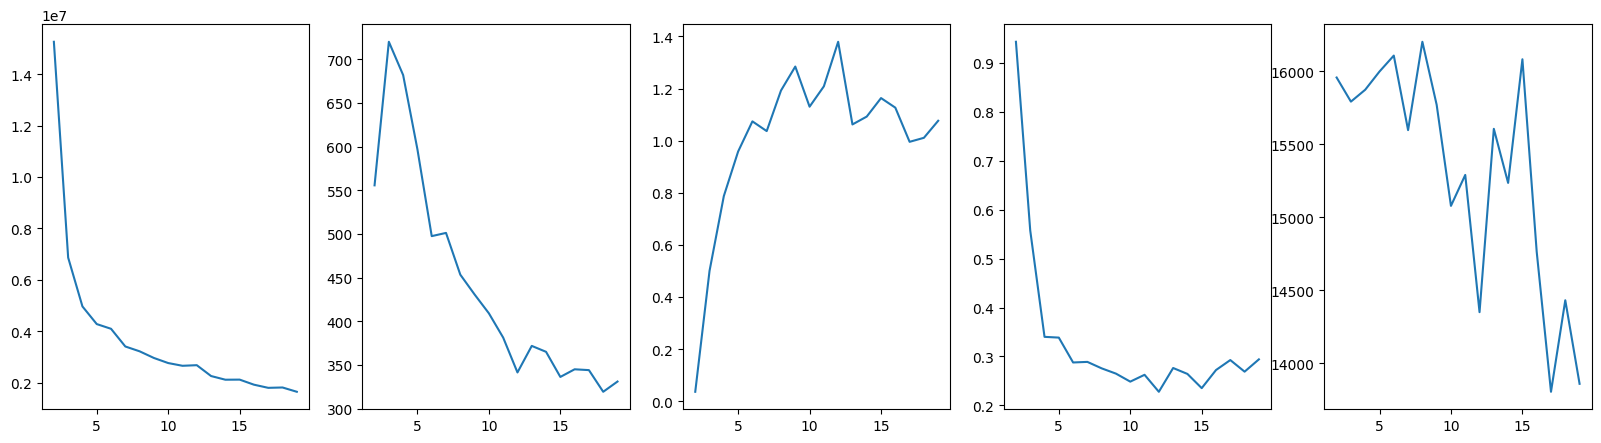

In [219]:
methods = ['elbow', 'calinski-harabasz', 'davies-bouldin', 'silhouette', 'bic']
fig, axs = plt.subplots(1, 5)

for i in range(len(methods)):
    method = methods[i]    
    axs[i].plot(range(min_k, max_k), scores[method])